In [1]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint, odeint_adjoint
import scipy.linalg as la
import scipy.integrate as integrate

from graphic_tools import simple_plotter, show_state, visualize_u_from_F, show_err
from burgers import get_burgers, get_burgers_fd, get_burgers_cons_fd, get_burgers_nicolson, get_burgers_fft
from generators import burgers_snapshot_generator, get_burgers_batch
from initial_functions import random_init, high_dim_random_init, burgers_analytical_init
from analysis_tools import relative_err, rmse, check_weights, downsampling
from training_dataset import generate_burgers_training_dataset, read_dataset
from models import HeatModel, BurgersModelA
from objectives import mse_fn, ae_fn

---

# Burgers equation - reconstruction experiments

--- 
##  Training

Let's make a set of initial conditions which will be used for references, training, validation and test

### Initial conditions

In [2]:
t_n = 64
x_n = 64
x_min = 0. # 0.
x_max = 1. # 1.
t_min = 0. # 0.
t_max = 0.5 # 0.5
nu = 0.03 # 0.03 (64 to 4096)

/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/burgers.py:38: RuntimeWarning: overflow encountered in multiply
  b = 0.25 * u[i-1, 1:-1] * ((u[i-1, 2:] - u[i-1, 0:-2]) / dx)
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/burgers.py:37: RuntimeWarning: invalid value encountered in subtract
  a = nu * (u[i-1, 2:] - 2 * u[i-1, 1:-1] + u[i-1, 0:-2]) / (dx**2)
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/burgers.py:37: RuntimeWarning: invalid value encountered in add
  a = nu * (u[i-1, 2:] - 2 * u[i-1, 1:-1] + u[i-1, 0:-2]) / (dx**2)
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/burgers.py:38: RuntimeWarning: invalid value encountered in subtract
  b = 0.25 * u[i-1, 1:-1] * ((u[i-1, 2:] - u[i-1, 0:-2]) / dx)
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/burgers.py:39: RuntimeWarning: invalid value encountered in add
  u[i, 1:-1] = u[i-1, 1:-1] + dt * (a - b)
/Users/vdesgran

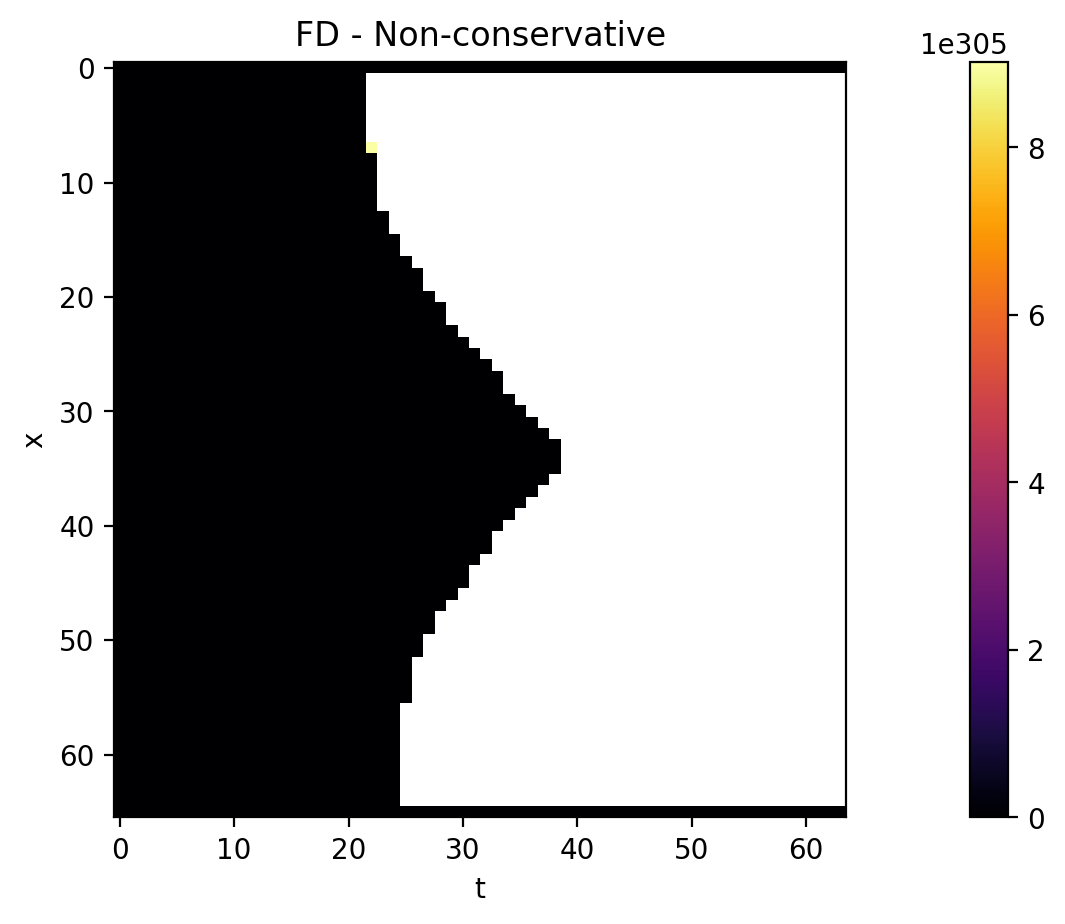

0.42558908462524414


/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/burgers.py:50: RuntimeWarning: overflow encountered in power
  f = lambda u : np.power(u, 2) / 2
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/burgers.py:54: RuntimeWarning: invalid value encountered in subtract
  b = ( 1 / (2 * dx)) * (f(u[i-1, 2:]) - f(u[i-1, 0:-2]))
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/burgers.py:55: RuntimeWarning: invalid value encountered in subtract
  u[i, 1:-1] = u[i-1, 1:-1] + dt * (a - b)
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/burgers.py:54: RuntimeWarning: overflow encountered in multiply
  b = ( 1 / (2 * dx)) * (f(u[i-1, 2:]) - f(u[i-1, 0:-2]))


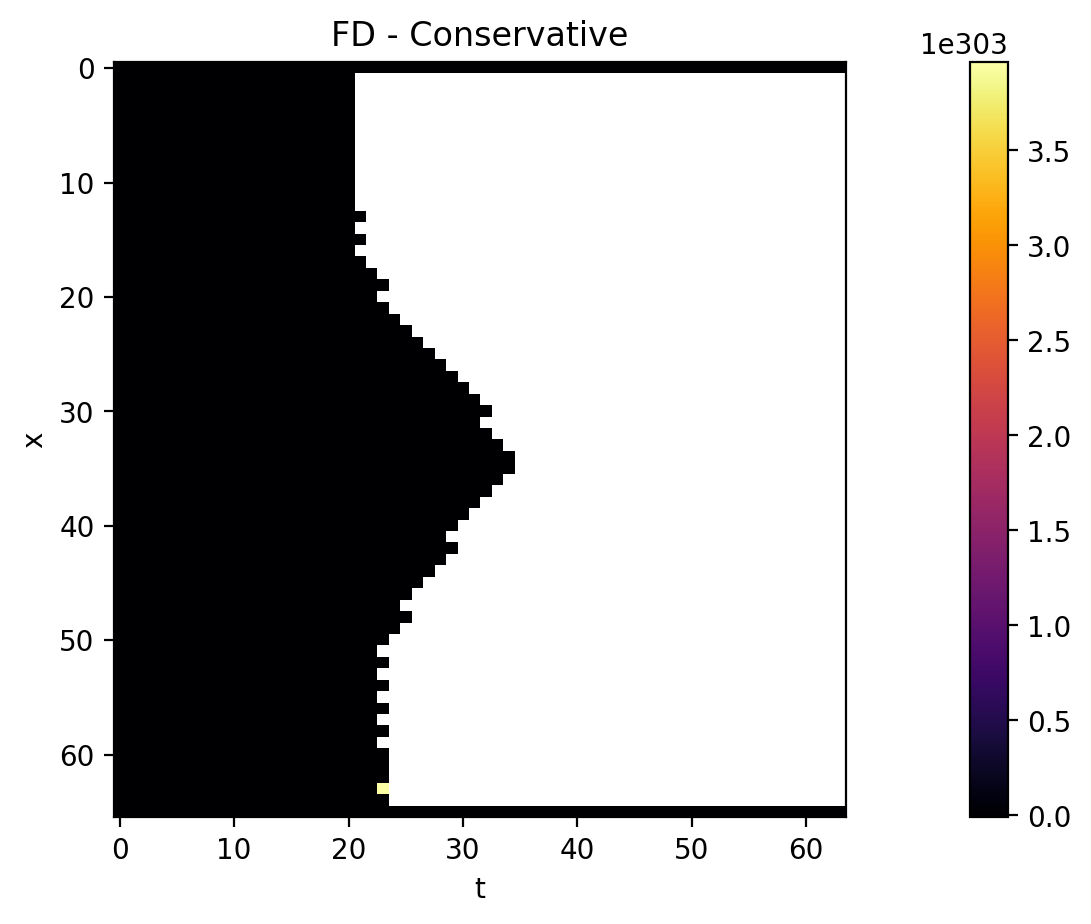

0.39783692359924316


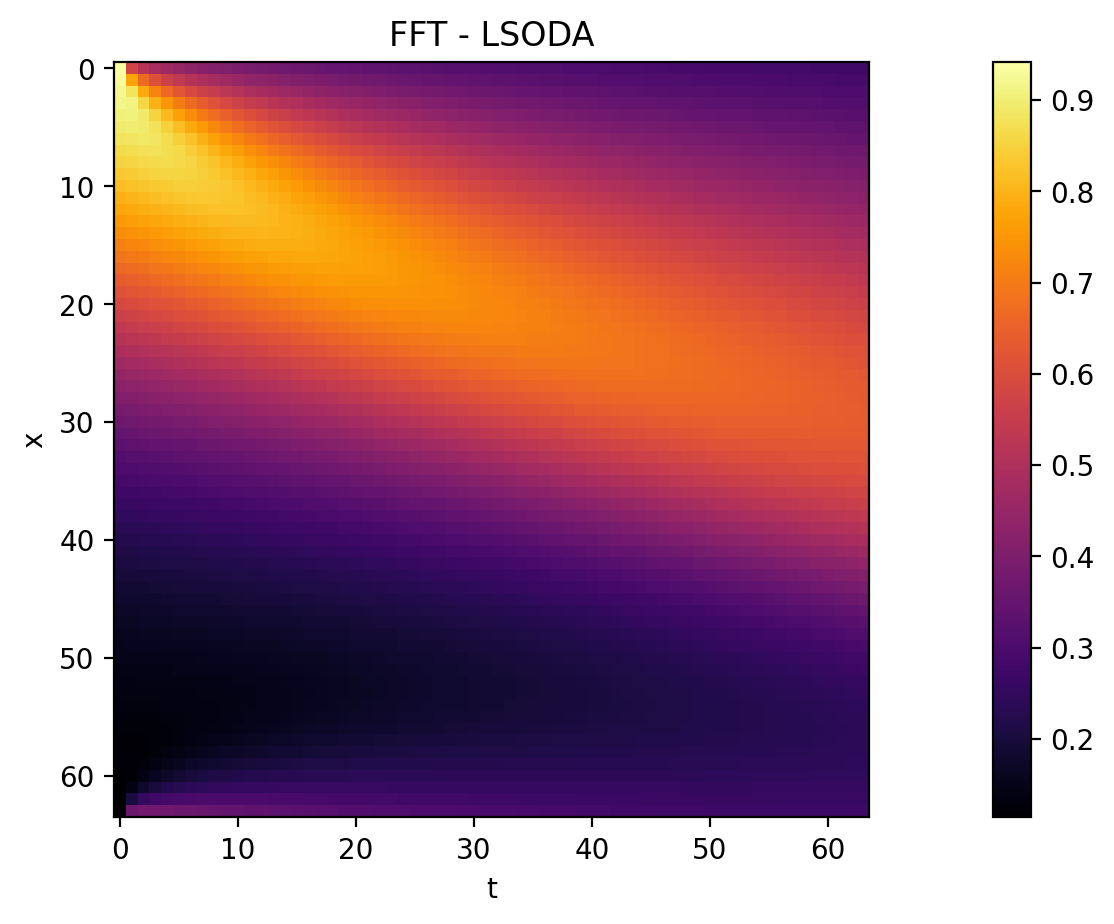

0.43500804901123047


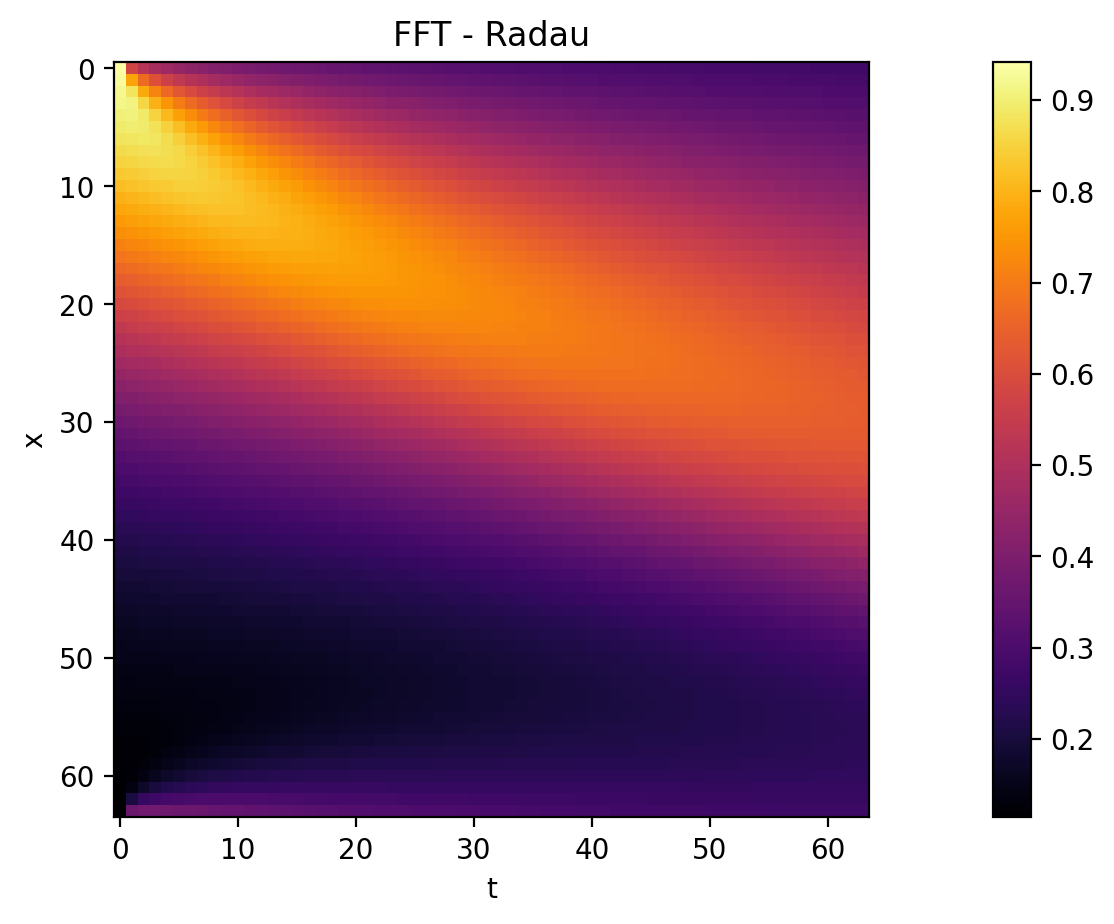

0.41336607933044434


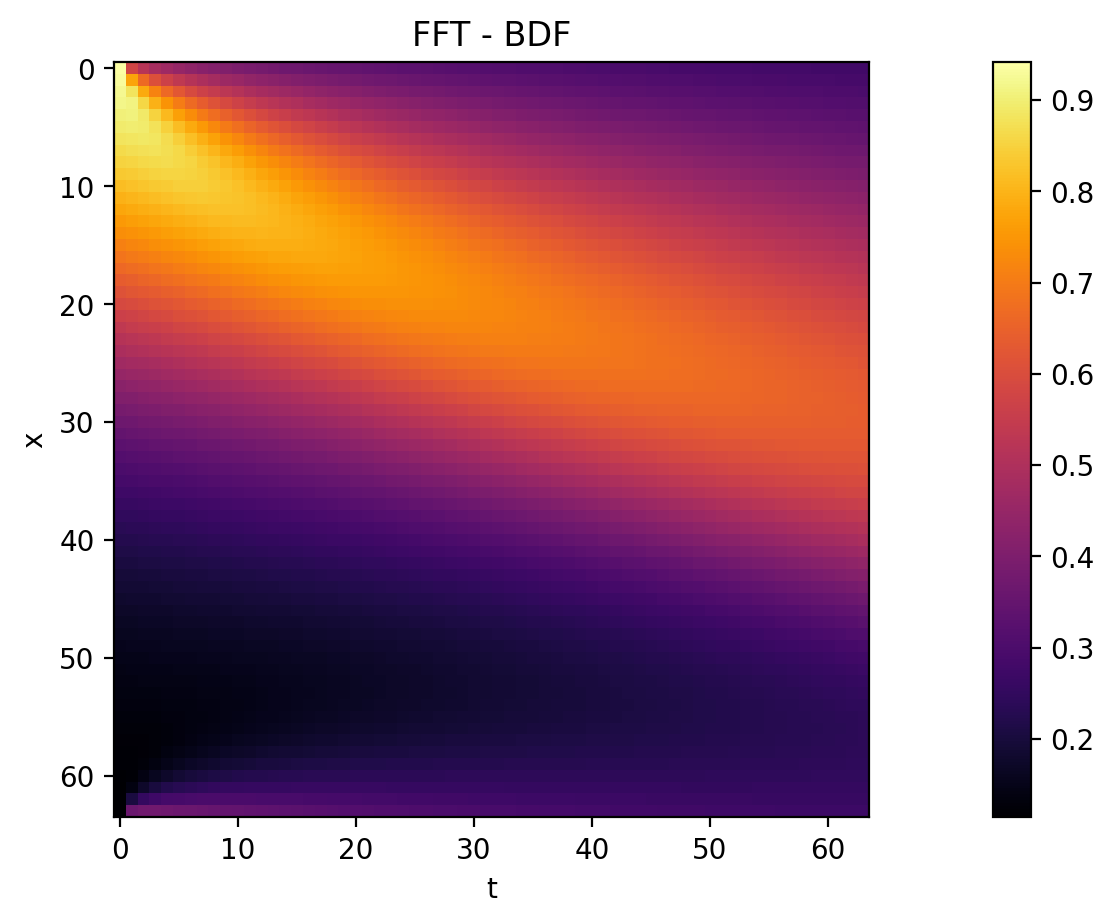

0.40802884101867676


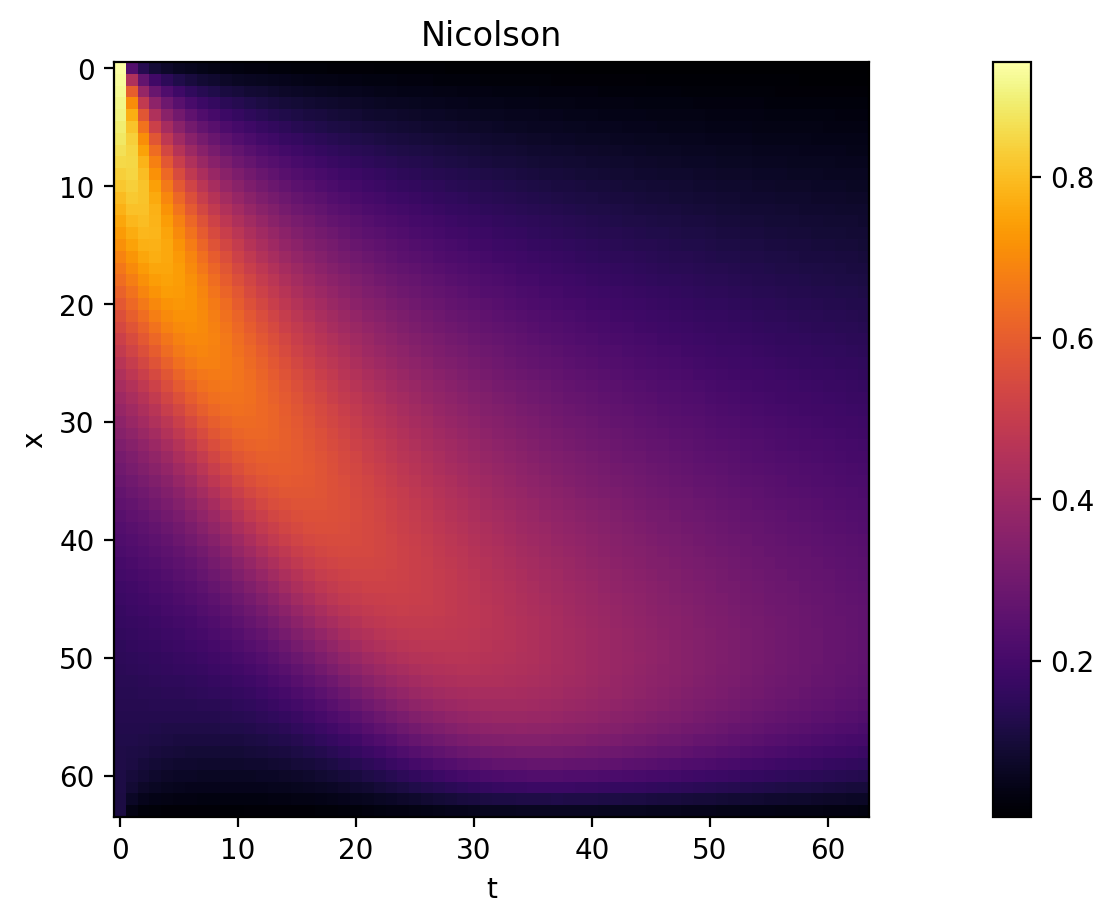

0.4639761447906494


In [3]:
# (Von Neumann analysis to do ?) Non-linear not possible
t, dt = np.linspace(t_min, t_max, t_n, retstep=True)
x, dx = np.linspace(x_min, x_max, x_n, retstep=True)

u0 = burgers_analytical_init(t, x, nu)

start = time.time()
u_df = get_burgers_fd(dt, dx, t_n, nu, u0)
show_state(u_df.T, 'FD - Non-conservative', 't', 'x', None)
print(time.time() - start)

start = time.time()
u_cons = get_burgers_cons_fd(dt, dx, t_n, nu, u0)
show_state(u_cons.T, 'FD - Conservative', 't', 'x', None)
print(time.time() - start)

start = time.time()
u_fft = get_burgers_fft(t, dx, x_n, nu, u0, method="LSODA")
show_state(u_fft.T, 'FFT - LSODA', 't', 'x', None)
print(time.time() - start)

start = time.time()
u_fft = get_burgers_fft(t, dx, x_n, nu, u0, method="Radau")
show_state(u_fft.T, 'FFT - Radau', 't', 'x', None)
print(time.time() - start)

start = time.time()
u_rad = get_burgers_fft(t, dx, x_n, nu, u0, method="BDF")
show_state(u_rad.T, 'FFT - BDF', 't', 'x', None)
print(time.time() - start)

start = time.time()
u_nic = get_burgers_nicolson(dt, dx, t_n, x_n, nu, u0)
show_state(u_nic.T, 'Nicolson', 't', 'x', None)
print(time.time() - start)

In [ ]:
snap = burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu, rand=-1, typ=1)
show_state(snap.T, "Snapshot")

---

## Operator F reconstruction

---

### Full-order model - Coarse grid

Several training datasets of high-dimension are generated, downsampled and compare to coarse grid solution as a point of comparison.

In [4]:
#training_set = generate_burgers_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, nu, 256, 1, './dataset/high_dim_random_burgers_training_set.pt')
training_set = read_dataset('dataset/high_dim_random_burgers_training_set.pt')

In [5]:
# def check_training_set(dataset):
#     for i in range(len(dataset)):
#         a, b, c, d = dataset[i]
#         show_state(b.T, i)

# check_training_set(training_set)

In [6]:
def coarse_reference(t_max, t_min, x_max, x_min, t_n, x_n, dataset):
    batch_size = len(dataset)
    
    t, dt = np.linspace(t_min, t_max, t_n, retstep=True)
    x, dx = np.linspace(x_min, x_max, x_n, retstep=True)

    rmse_tot = 0
    re_tot = 0
    for i in range(batch_size):
        # Get downsize solution
        t, u, _, _ = dataset[i]
        u = u.detach().numpy()
        
        # Generate coarse grid solution
        u0 = np.zeros((t_n, x_n + 2))
        u0[0, 1:-1] = u[0, :]
        pred_u = get_burgers_fft(t, dx, x_n, nu, u0, method="BDF")
        
        # Compute rmse and relative error
        re_tot += relative_err(u.T, pred_u.T)
        rmse_tot += rmse(pred_u.T, u.T)

    print(rmse_tot / batch_size)
    print(np.mean(re_tot) / batch_size)

coarse_reference(t_max, t_min, x_max, x_min, t_n, x_n, training_set)

0.1540448550337976
2.5839327387793714


### Model used by ODE solver

Let's define a few neural ODE model to use. First, with a basic linear one-layer model, efficient to work on linear PDE like Heat equation, but not for a non-linear PDE such as the Burgers equation.

In [77]:
class BurgersModelB(nn.Module):
    def __init__(self, n):
        super(BurgersModelB, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, n, n, 3),
            nn.ELU(),
            nn.Conv1d(1, n, int(n/2), 3),
            nn.ELU(),
            nn.ConvTranspose1d(1, int(n/2), n, 3),
            nn.ELU(),
            nn.ConvTranspose1d(1, n, n, 3),
            nn.Tanh()
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        return self.net(u)

### Training - continuous residual

In [13]:
loss_fn = mfe_fn

In [14]:
def training_step(net, t, data, tr_min_t, tr_max_t):
    t, bu, _, _ = data
    tr_t =  t[tr_min_t:tr_max_t]
    tr_b0 = bu[tr_min_t, :]
    tr_bu = bu[tr_min_t:tr_max_t, :]
    
    pred_u = odeint(net, tr_b0, tr_t) # Reference
    loss = loss_fn(pred_u.T, tr_bu.T)
    
    return loss

In [94]:
def training_ode_solver_net(net, epochs, t_n, x_n, dataset, val_epoch=10, rands=[], downsize=0):
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    training_batch_size = len(dataset)
    training_set_idx = np.arange(0, training_batch_size)
    
    tr_min_t = 1
    tr_max_t = int(len(dataset[0][0]) / 5 * 5)
    val_max_t = int(tr_max_t + len(dataset[0][0]) / 5 * 0)
    
    for e in range(1, epochs + 1):
        loss_tot = 0
        val_loss_tot = 0
        #np.random.shuffle(training_set_idx)
        
        # === Train ===
        net.train()
        for i in training_set_idx:
            # === Randomness ====
            rand = -1
            if (i < len(rands)):
                rand = rands[i]
            
            optimizer.zero_grad()
            
            t, bu, _, _ = dataset[i]
            tr_t =  t[tr_min_t:tr_max_t]
            tr_b0 = bu[tr_min_t, :]
            tr_bu = bu[tr_min_t:tr_max_t, :]
            
            pred_u = odeint(net, tr_b0, tr_t) # [1:-1]
            loss = loss_fn(pred_u.T, tr_bu.T) # [:, 1:-1]
            loss_tot += loss.item()
            
            loss.backward(retain_graph=False) # retain_graph=True if 2+ losses
            optimizer.step()
        
        print('Epoch %d loss %f'%(e, float(loss_tot / float(training_batch_size))))
        
        # === Evaluate ===
        net.eval()
        if (e > val_epoch):
            for j in training_set_idx:
                t, bu, _, _ = dataset[j]
                val_t = t[tr_max_t:val_max_t]
                val_b0 = bu[tr_max_t, :]
                val_bu = bu[tr_max_t:val_max_t, :]
                
                val_pred_u = odeint(net, val_b0, val_t)
                val_loss = loss_fn(val_pred_u.T, val_bu.T)
                val_loss_tot += val_loss.item()
            print('Epoch %d validation loss %f'%(e, float(val_loss_tot / float(training_batch_size))))
        
        if e % 10 == 0:
            sample_t, sample_b0, sample_real = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, rand, -1)
            sample_b0 = sample_real[0, :]
            sample_pred = odeint(net, sample_b0, sample_t)
            # sample_pred = odeint(net, sample_b0, torch.from_numpy(np.linspace(0,5,640)).float())
            show_state(sample_real[1:].T, 'Real', 't', 'x', None)
            show_state(sample_pred.detach().numpy().T, 'Determined', 't', 'x', None)
    
    return net

### Training

Epoch 1 loss 0.390991
Epoch 2 loss 0.377603
Epoch 3 loss 0.364336
Epoch 4 loss 0.347894
Epoch 5 loss 0.330580
Epoch 6 loss 0.315071
Epoch 7 loss 0.302954
Epoch 8 loss 0.294365
Epoch 9 loss 0.288694
Epoch 10 loss 0.285159


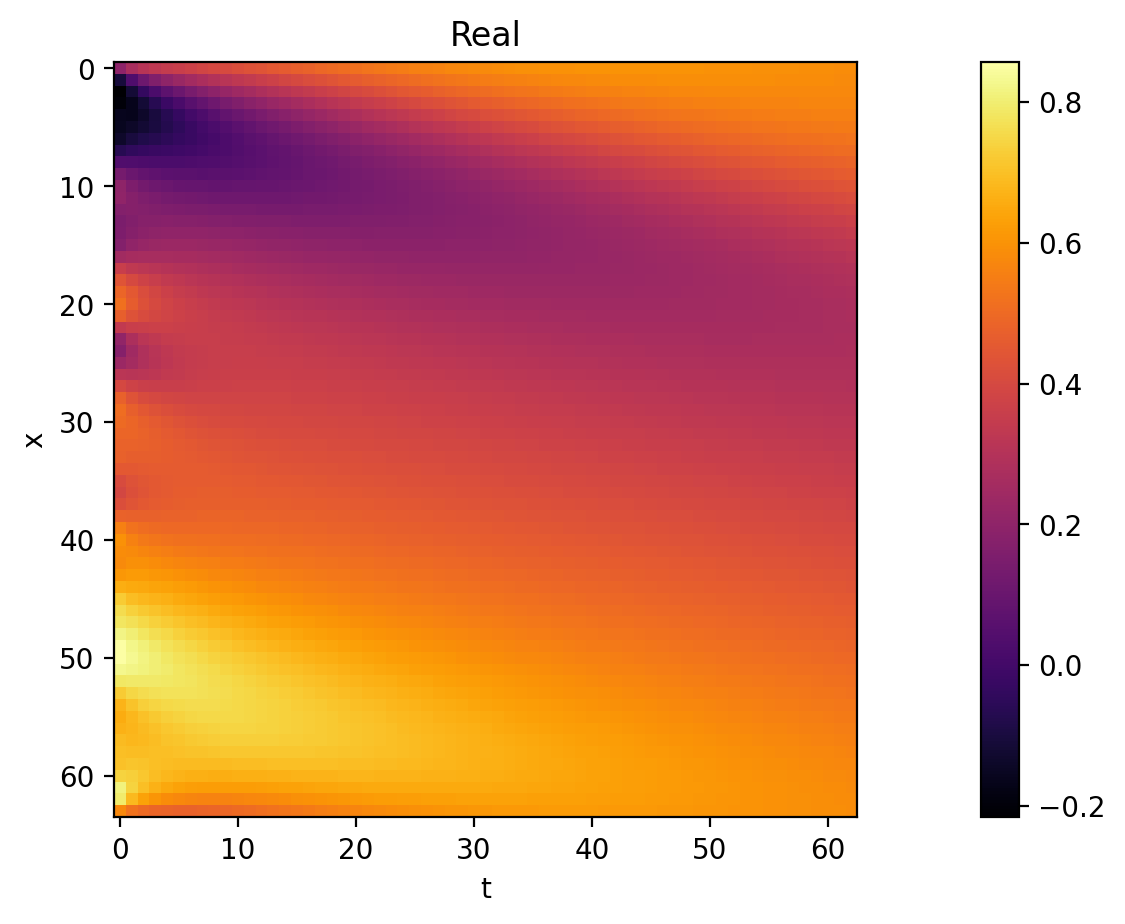

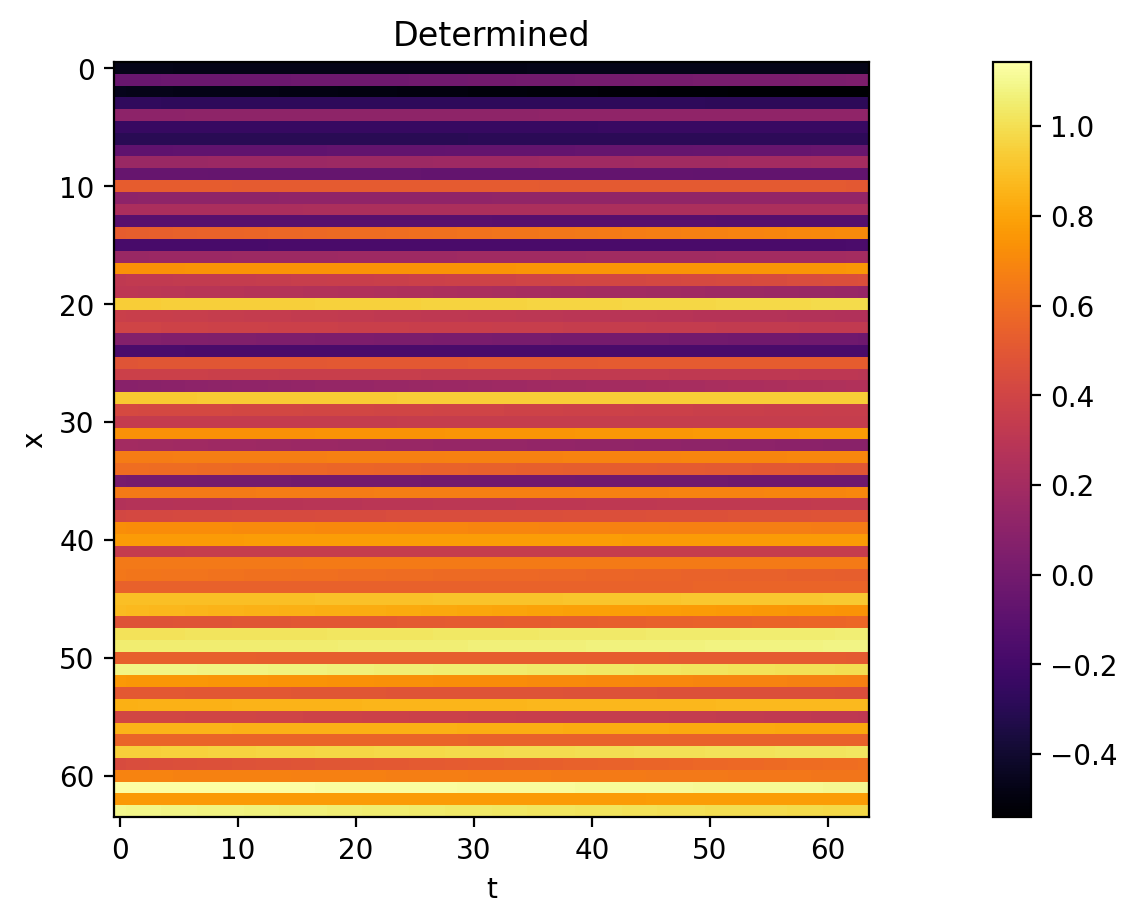

Epoch 11 loss 0.283042
Epoch 12 loss 0.281810
Epoch 13 loss 0.281104
Epoch 14 loss 0.280684
Epoch 15 loss 0.280423
Epoch 16 loss 0.280263
Epoch 17 loss 0.280165
Epoch 18 loss 0.280097
Epoch 19 loss 0.280047
Epoch 20 loss 0.280011


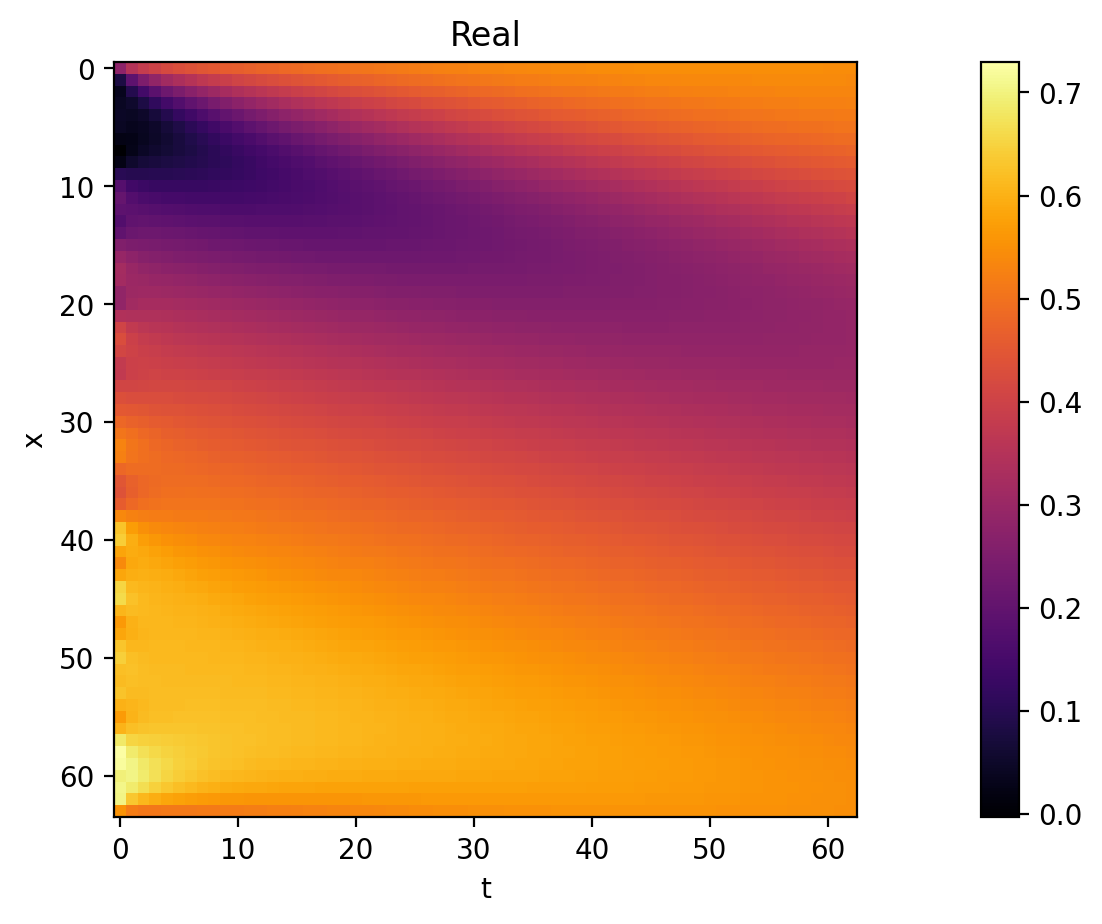

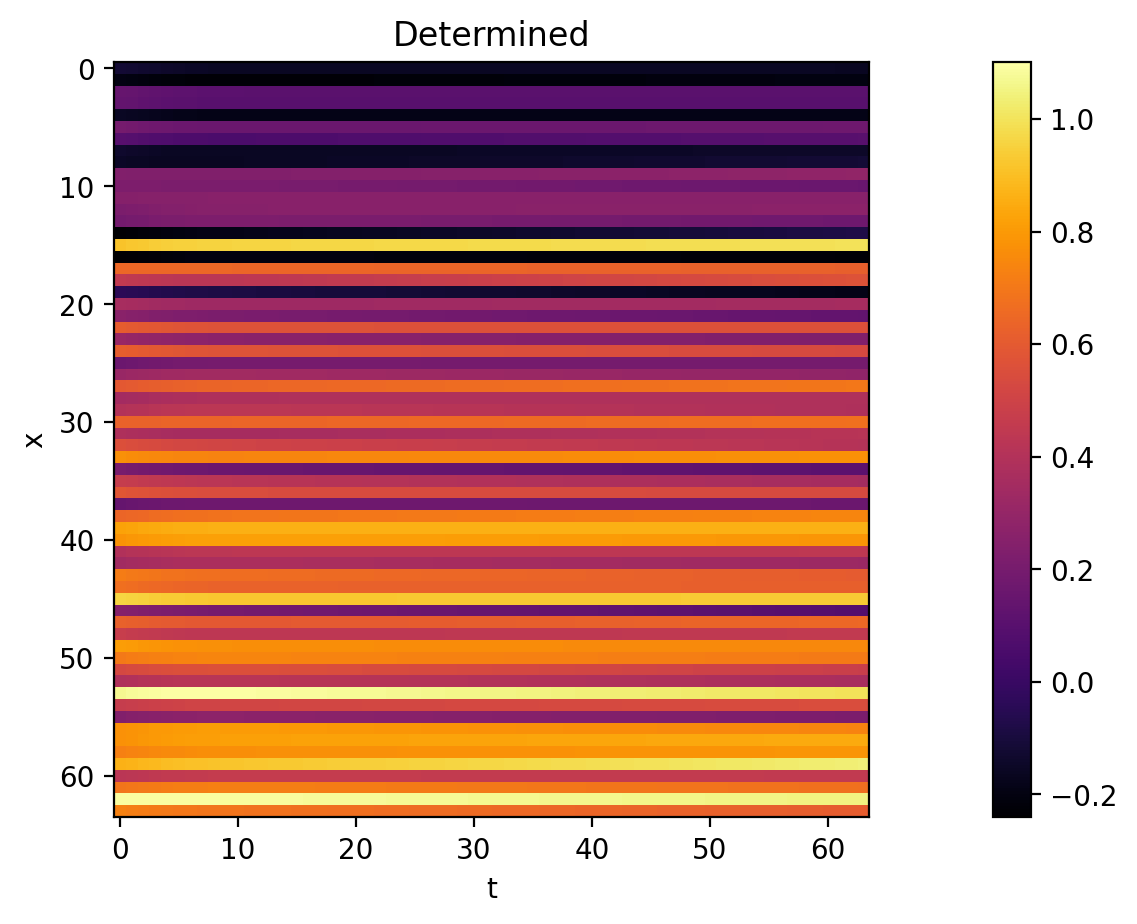

Epoch 21 loss 0.279981
Epoch 22 loss 0.279957
Epoch 23 loss 0.279943
Epoch 24 loss 0.279939
Epoch 25 loss 0.279936
Epoch 26 loss 0.279930
Epoch 27 loss 0.279921
Epoch 28 loss 0.279912
Epoch 29 loss 0.279905
Epoch 30 loss 0.279901


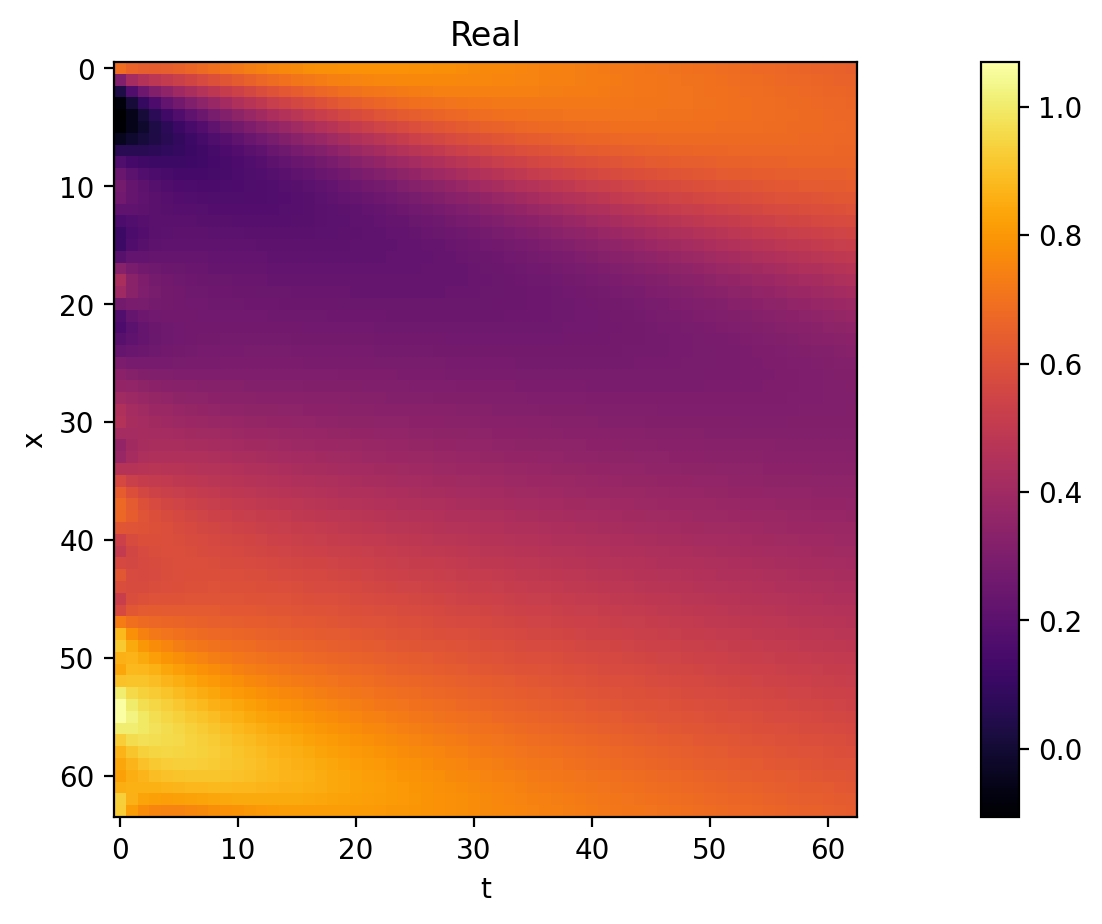

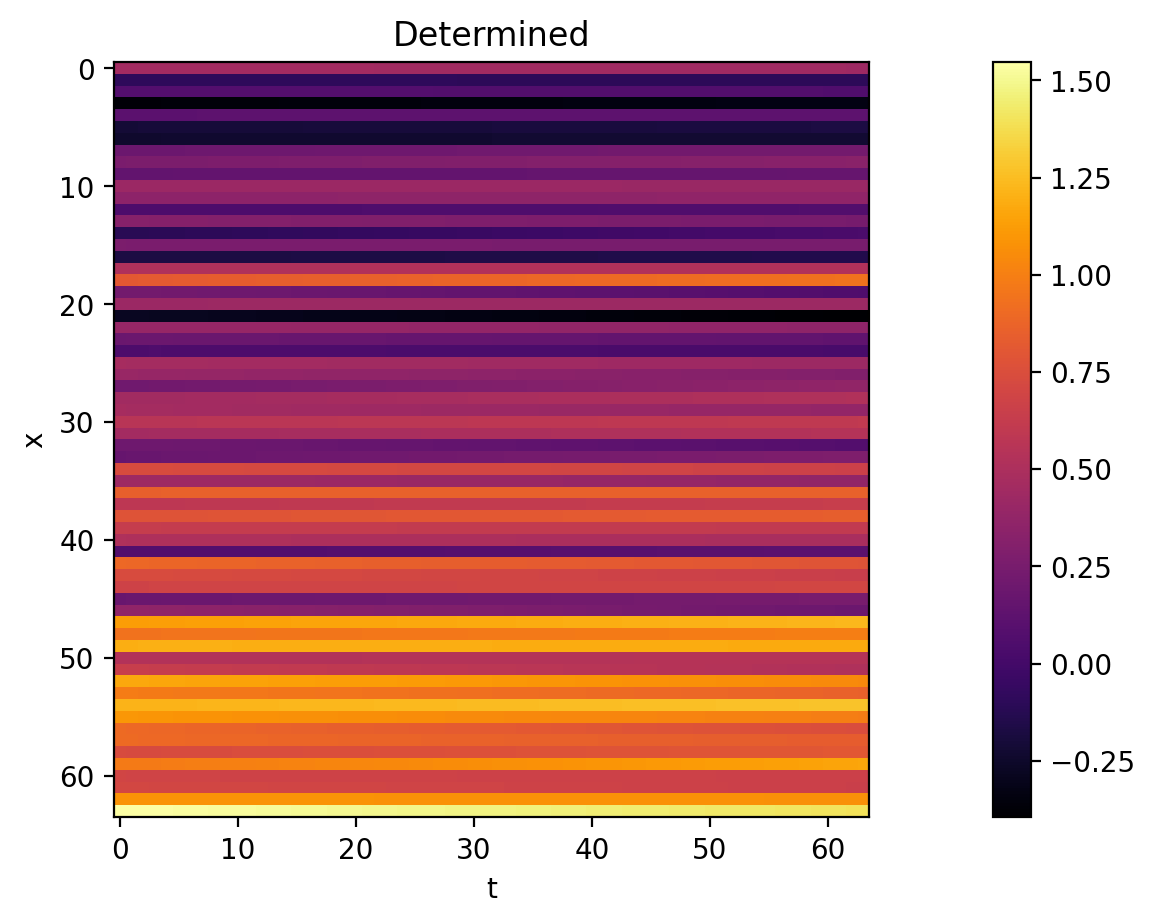

Epoch 31 loss 0.279898
Epoch 32 loss 0.279895
Epoch 33 loss 0.279891
Epoch 34 loss 0.279888
Epoch 35 loss 0.279886
Epoch 36 loss 0.279883
Epoch 37 loss 0.279881
Epoch 38 loss 0.279881
Epoch 39 loss 0.279881
Epoch 40 loss 0.279880


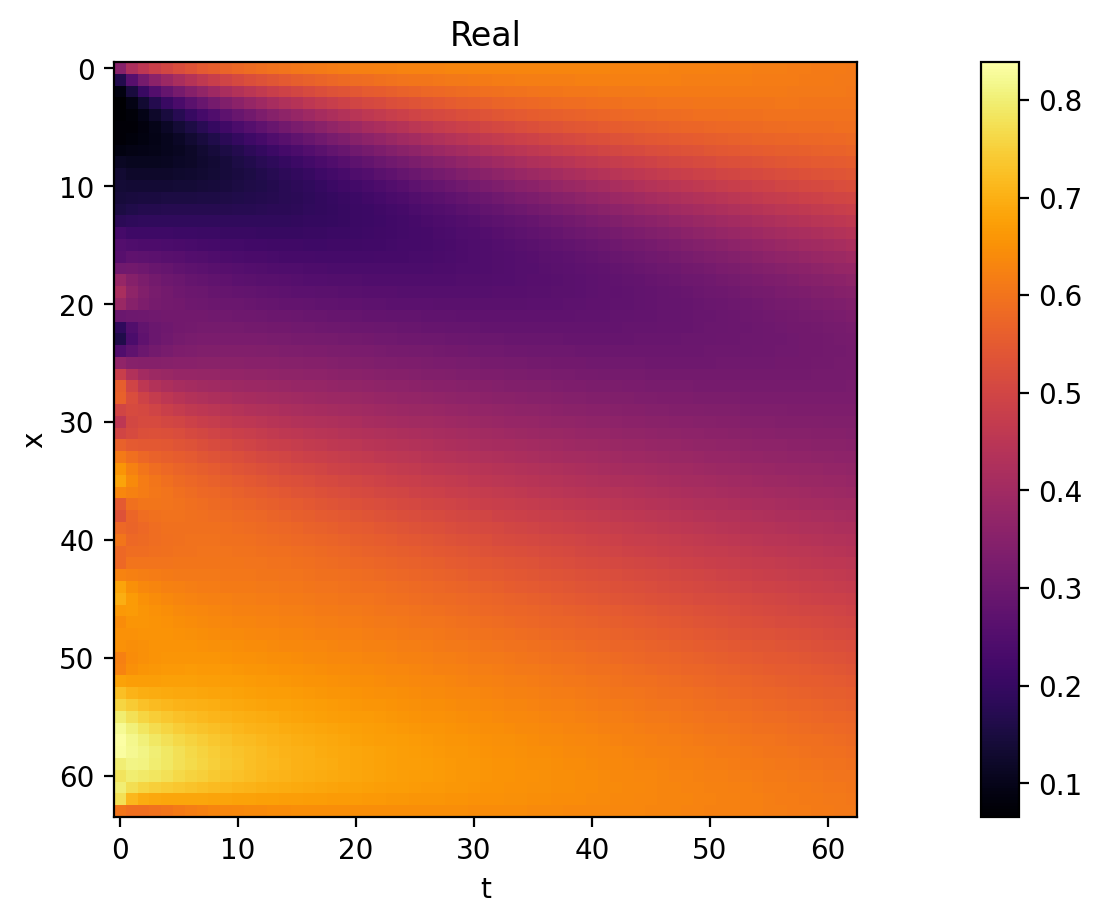

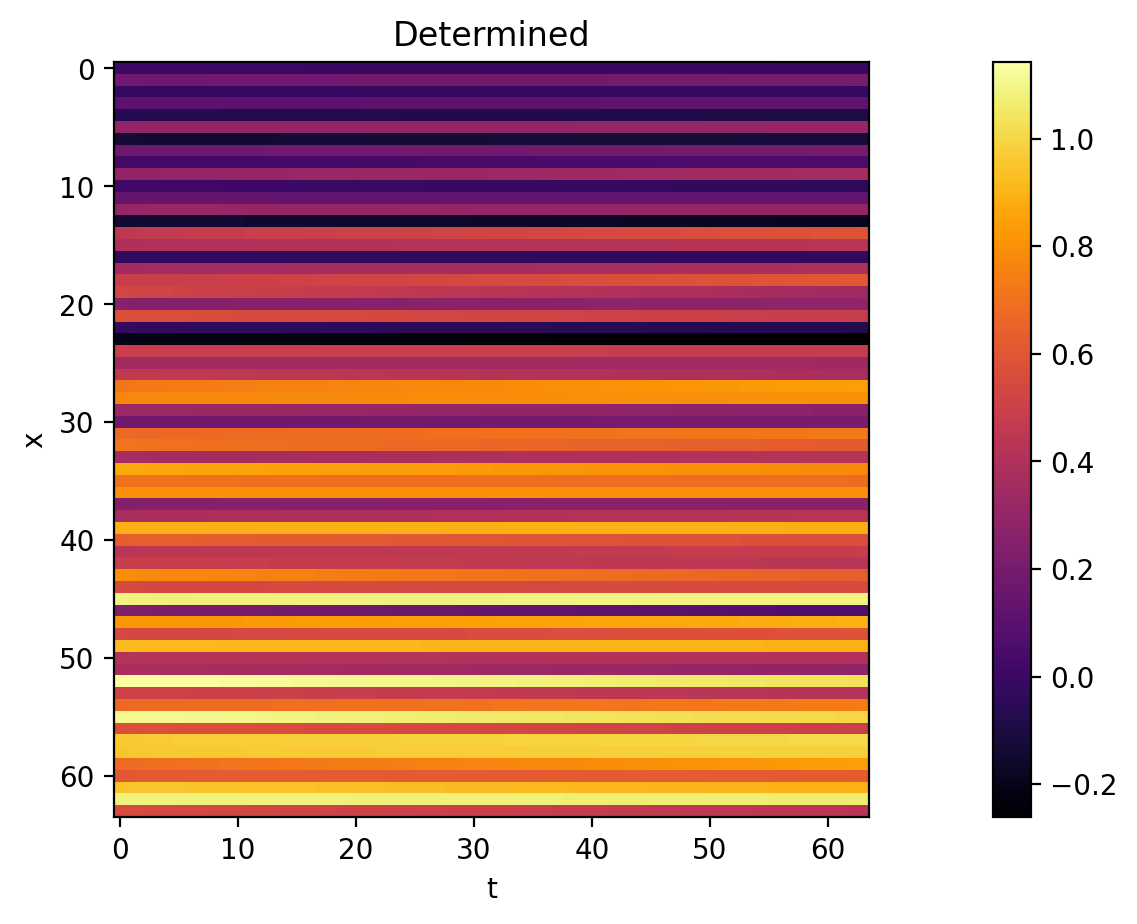

Epoch 41 loss 0.279878
Epoch 42 loss 0.279877
Epoch 43 loss 0.279876
Epoch 44 loss 0.279875
Epoch 45 loss 0.279874
Epoch 46 loss 0.279873
Epoch 47 loss 0.279872
Epoch 48 loss 0.279872
Epoch 49 loss 0.279873
Epoch 50 loss 0.279872


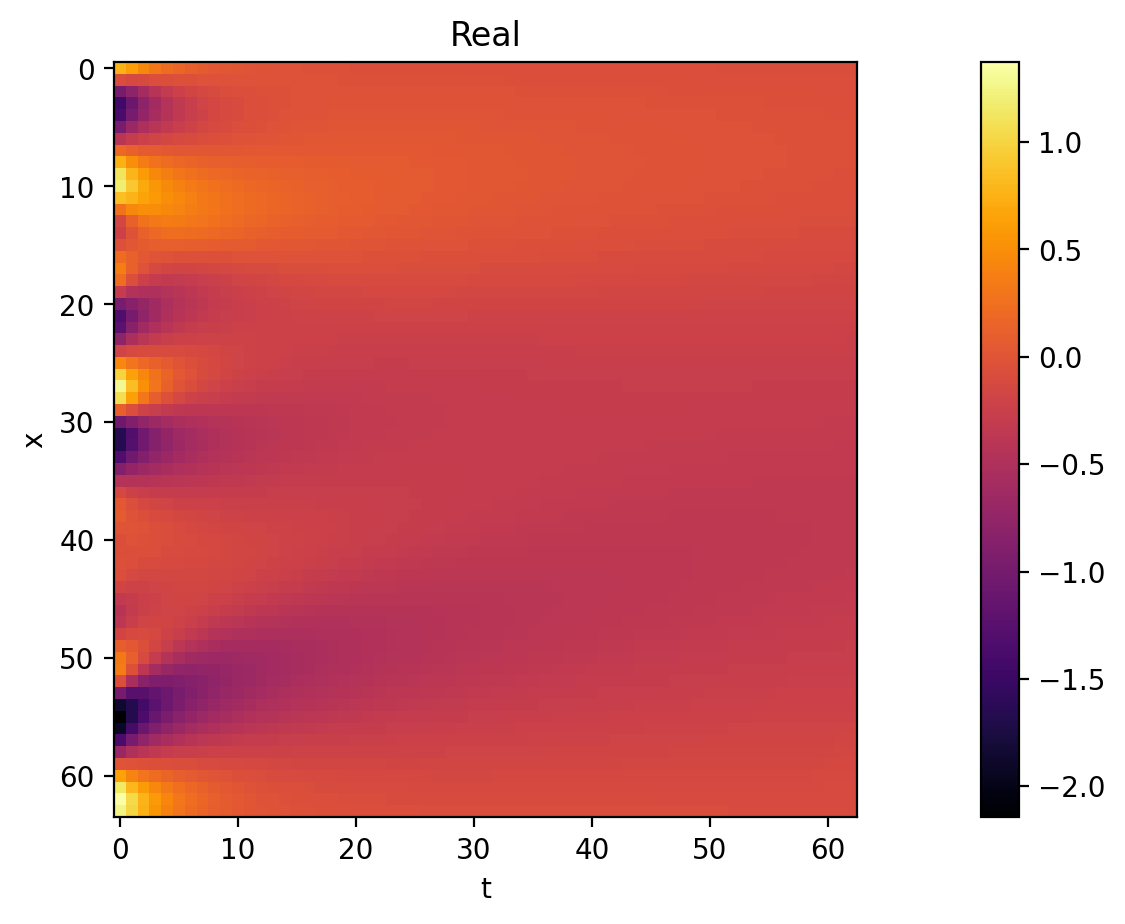

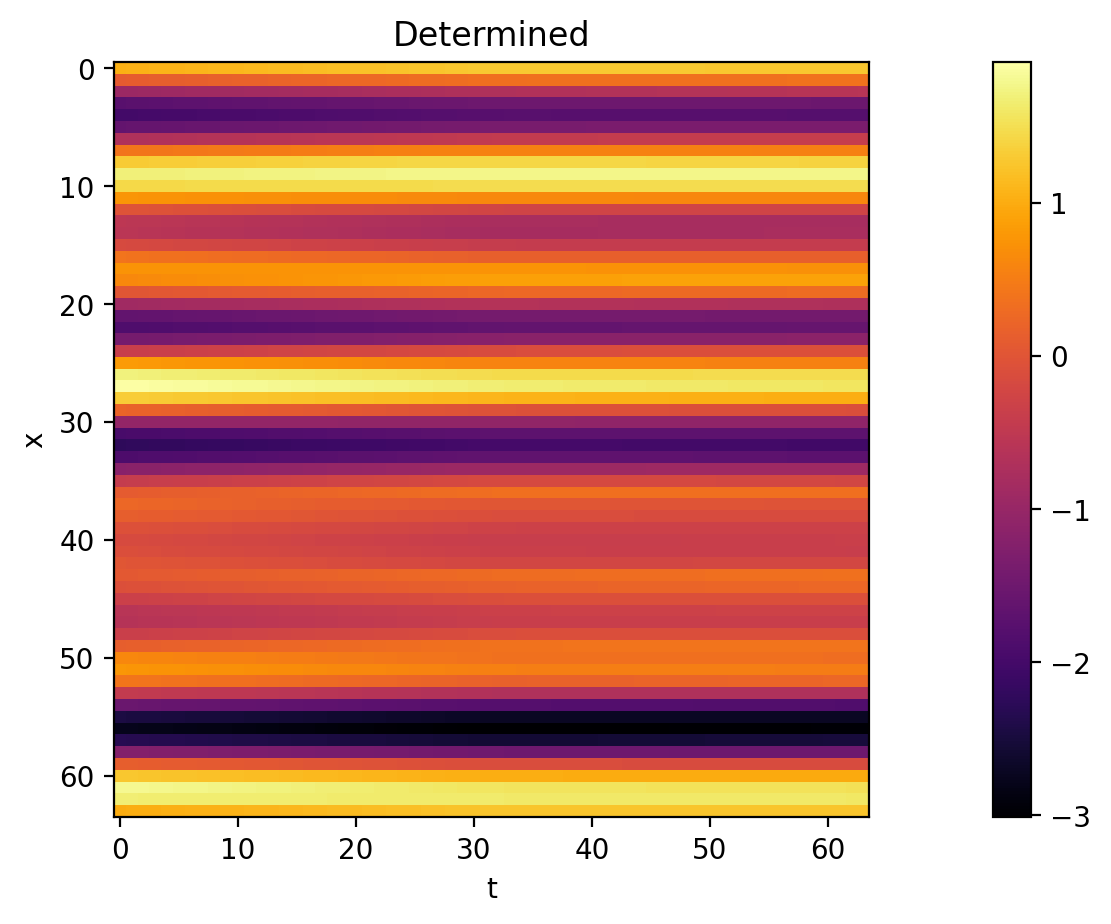

Epoch 51 loss 0.279870
Epoch 52 loss 0.279868
Epoch 53 loss 0.279866
Epoch 54 loss 0.279865
Epoch 55 loss 0.279864
Epoch 56 loss 0.279862
Epoch 57 loss 0.279860
Epoch 58 loss 0.279857
Epoch 59 loss 0.279854
Epoch 60 loss 0.279852


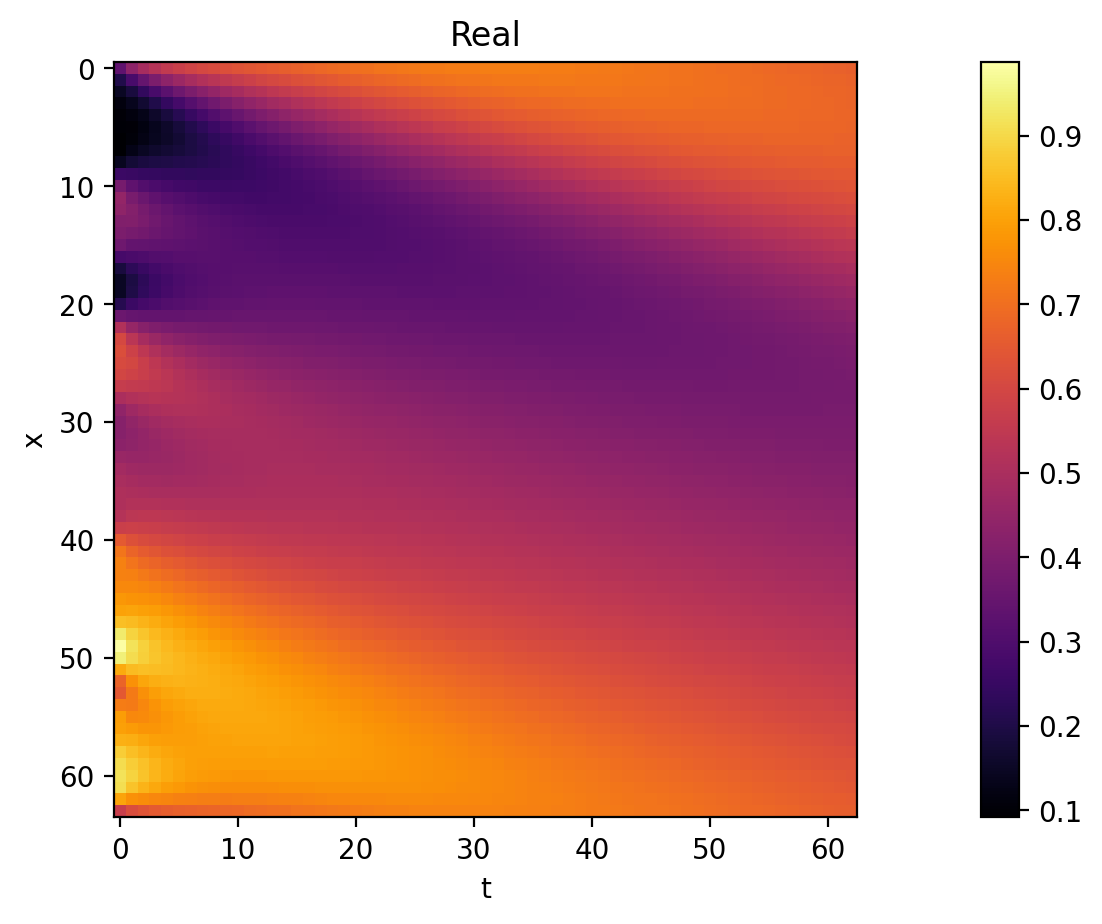

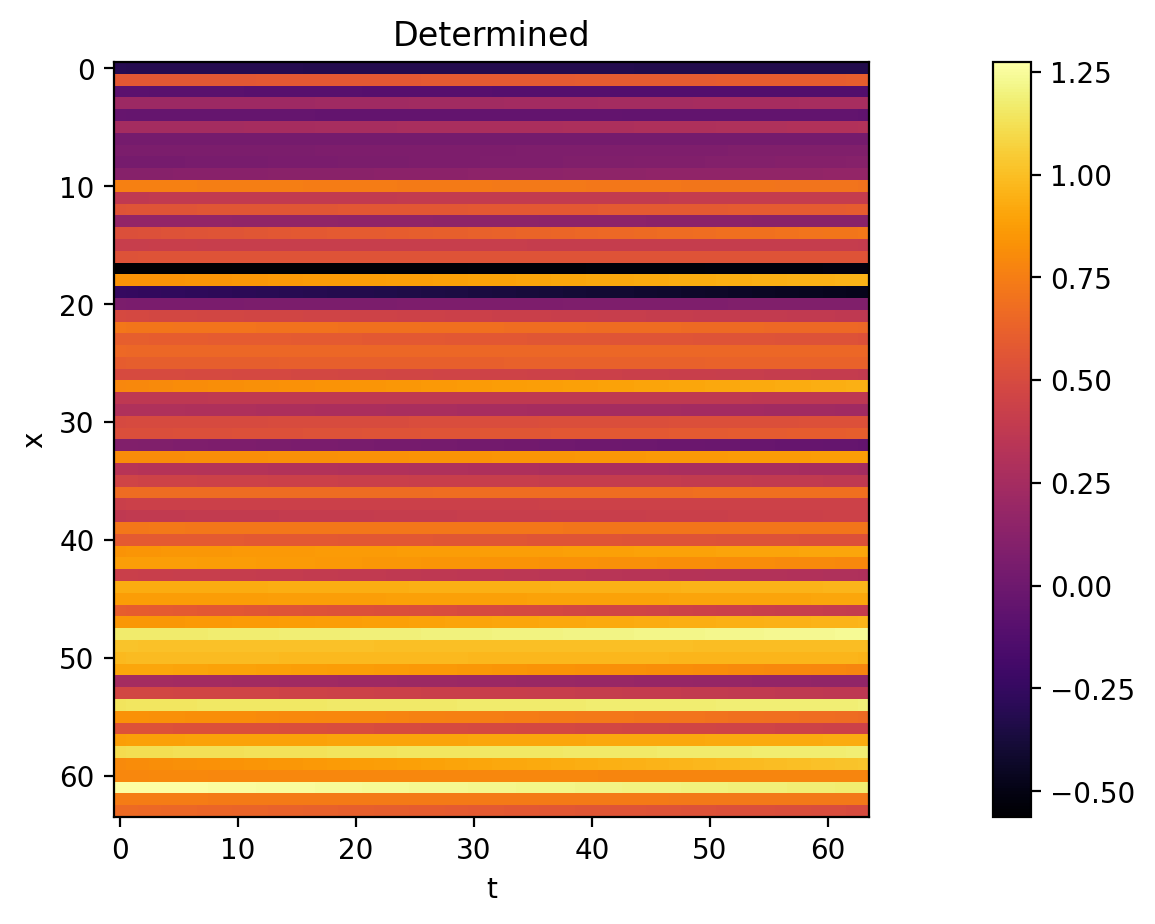

Epoch 61 loss 0.279854
Epoch 62 loss 0.279857
Epoch 63 loss 0.279857
Epoch 64 loss 0.279855
Epoch 65 loss 0.279852
Epoch 66 loss 0.279852
Epoch 67 loss 0.279853
Epoch 68 loss 0.279853
Epoch 69 loss 0.279854
Epoch 70 loss 0.279854


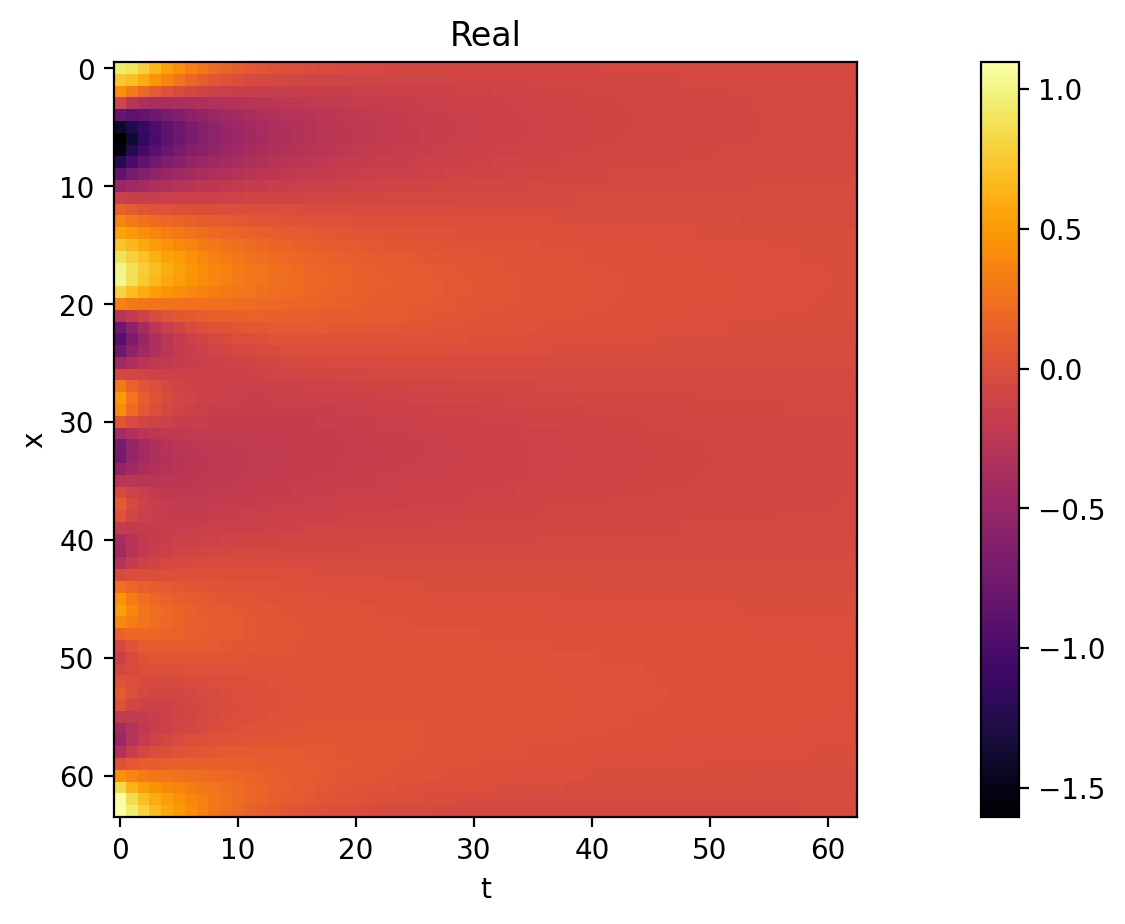

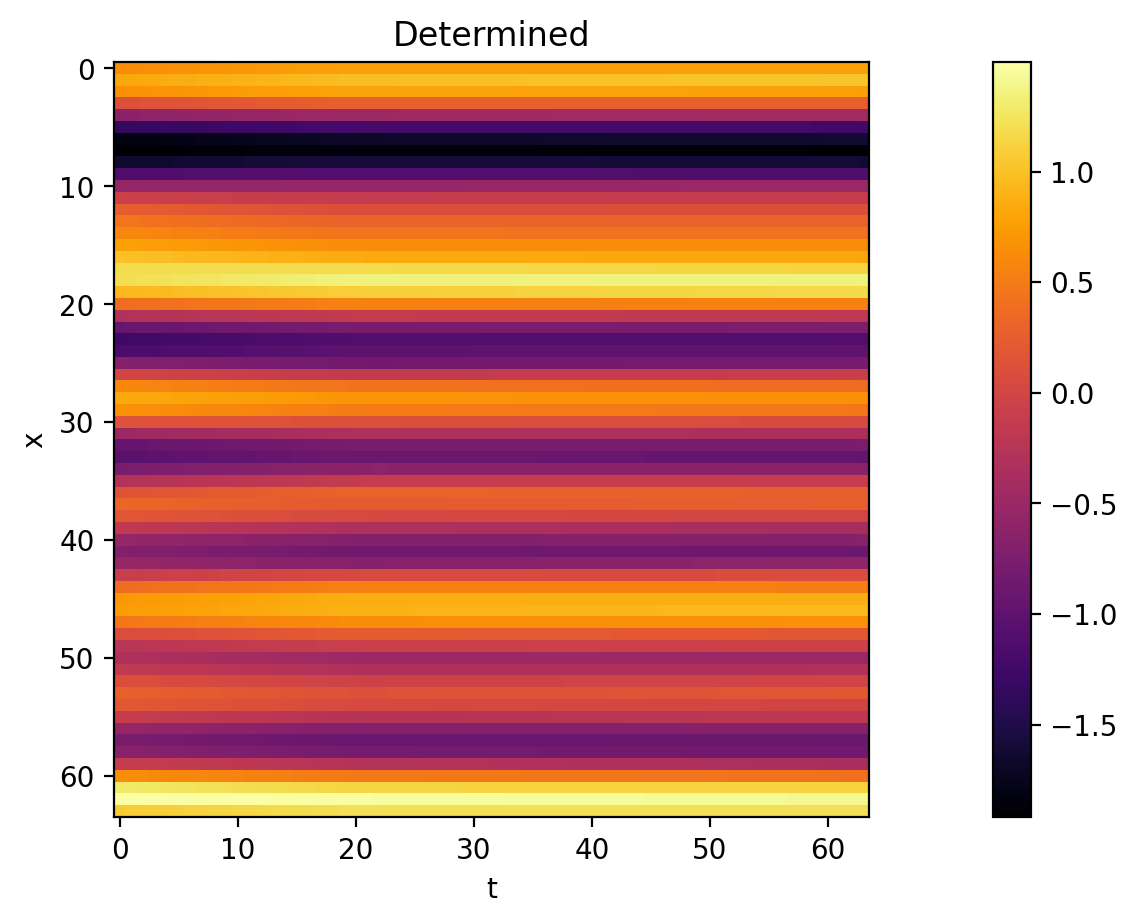

Epoch 71 loss 0.279854
Epoch 72 loss 0.279853
Epoch 73 loss 0.279853
Epoch 74 loss 0.279852
Epoch 75 loss 0.279851
Epoch 76 loss 0.279851
Epoch 77 loss 0.279852
Epoch 78 loss 0.279852
Epoch 79 loss 0.279852
Epoch 80 loss 0.279852


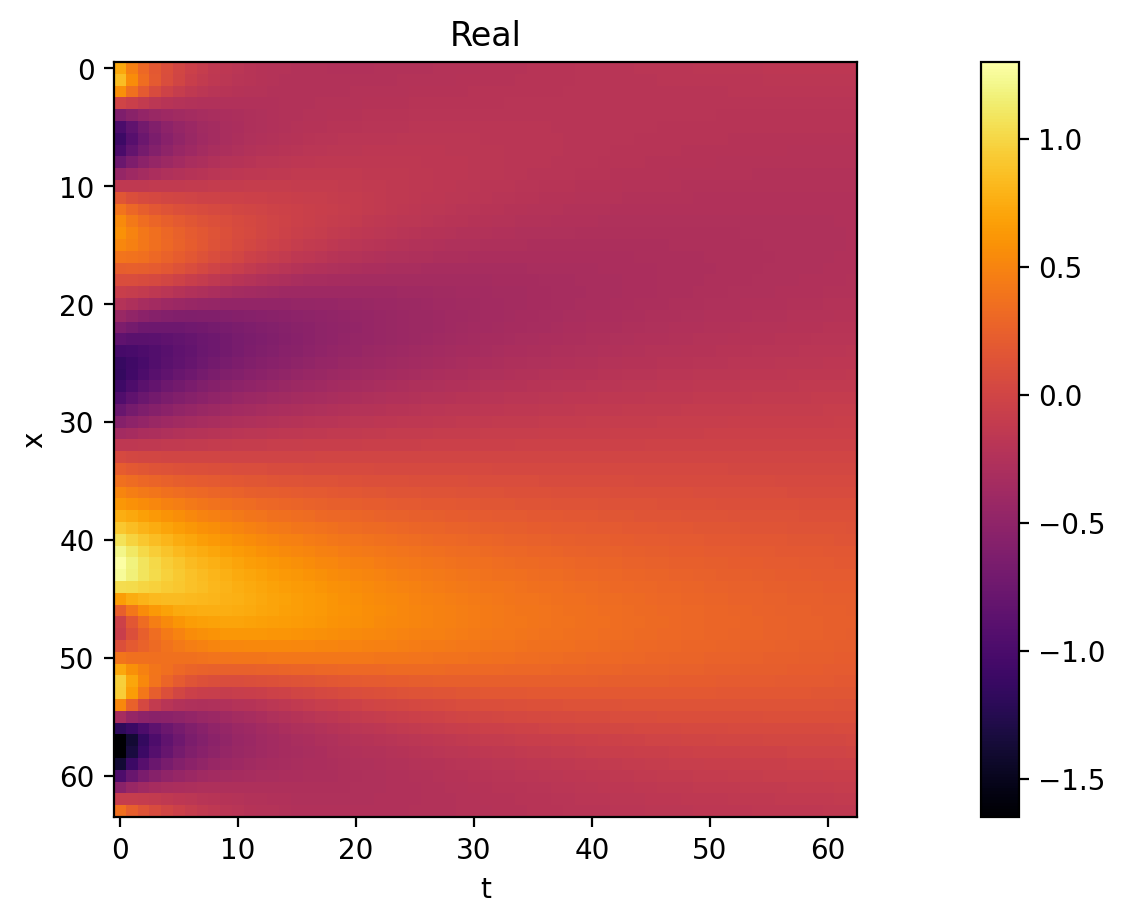

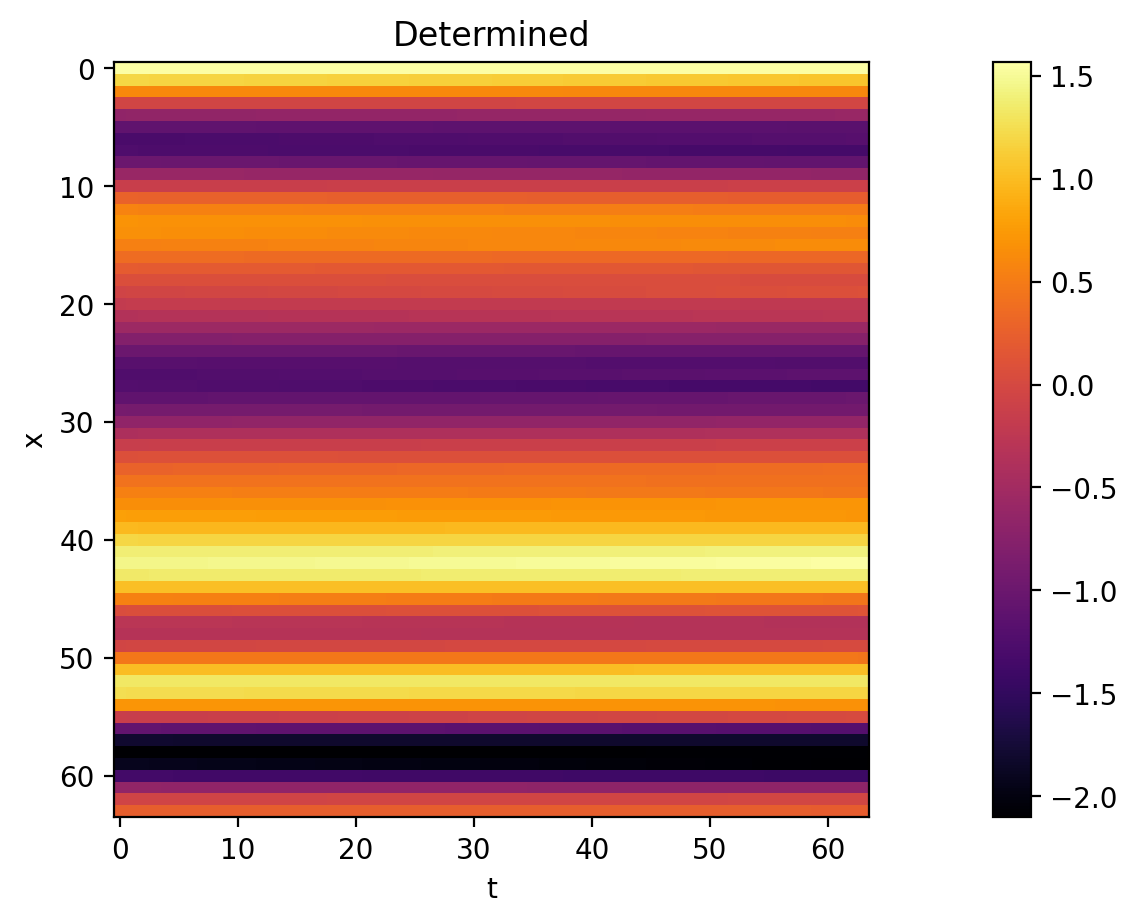

Epoch 81 loss 0.279851
Epoch 82 loss 0.279851
Epoch 83 loss 0.279851
Epoch 84 loss 0.279851
Epoch 85 loss 0.279851
Epoch 86 loss 0.279851
Epoch 87 loss 0.279851
Epoch 88 loss 0.279851
Epoch 89 loss 0.279851
Epoch 90 loss 0.279851


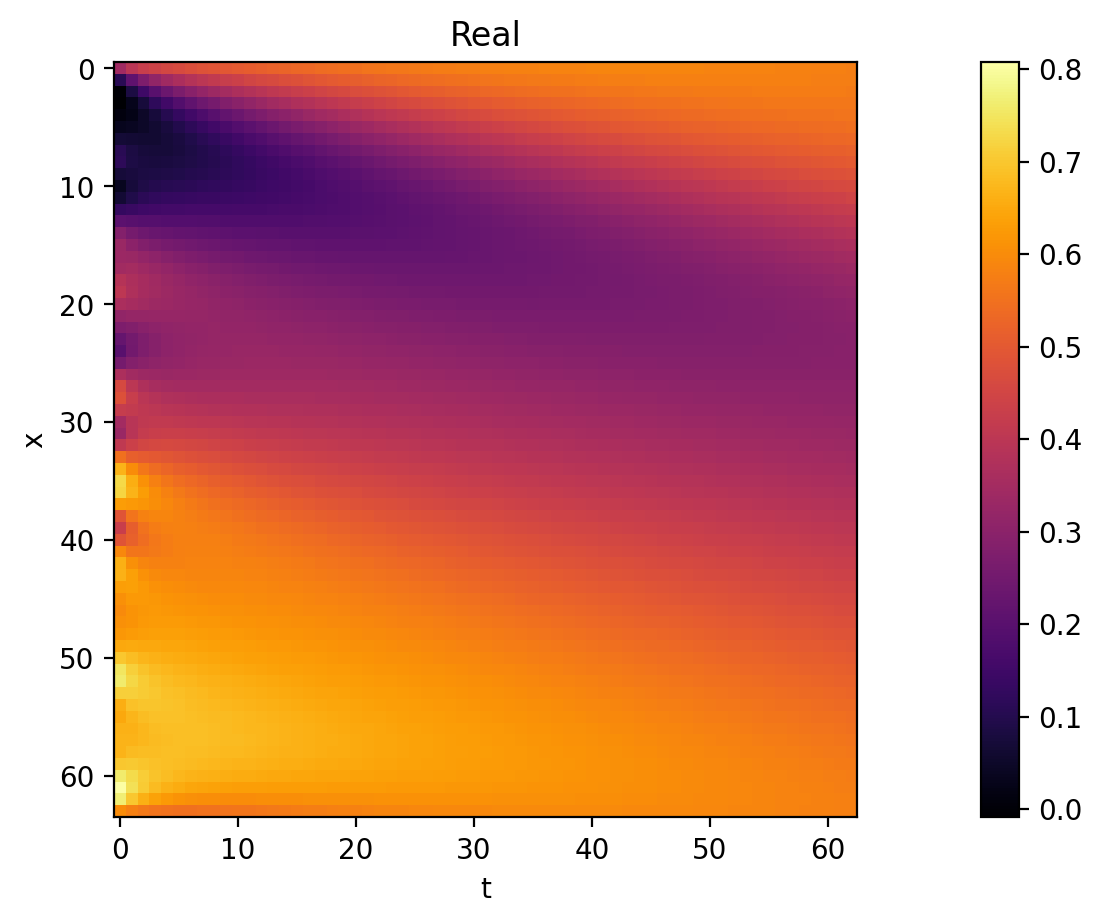

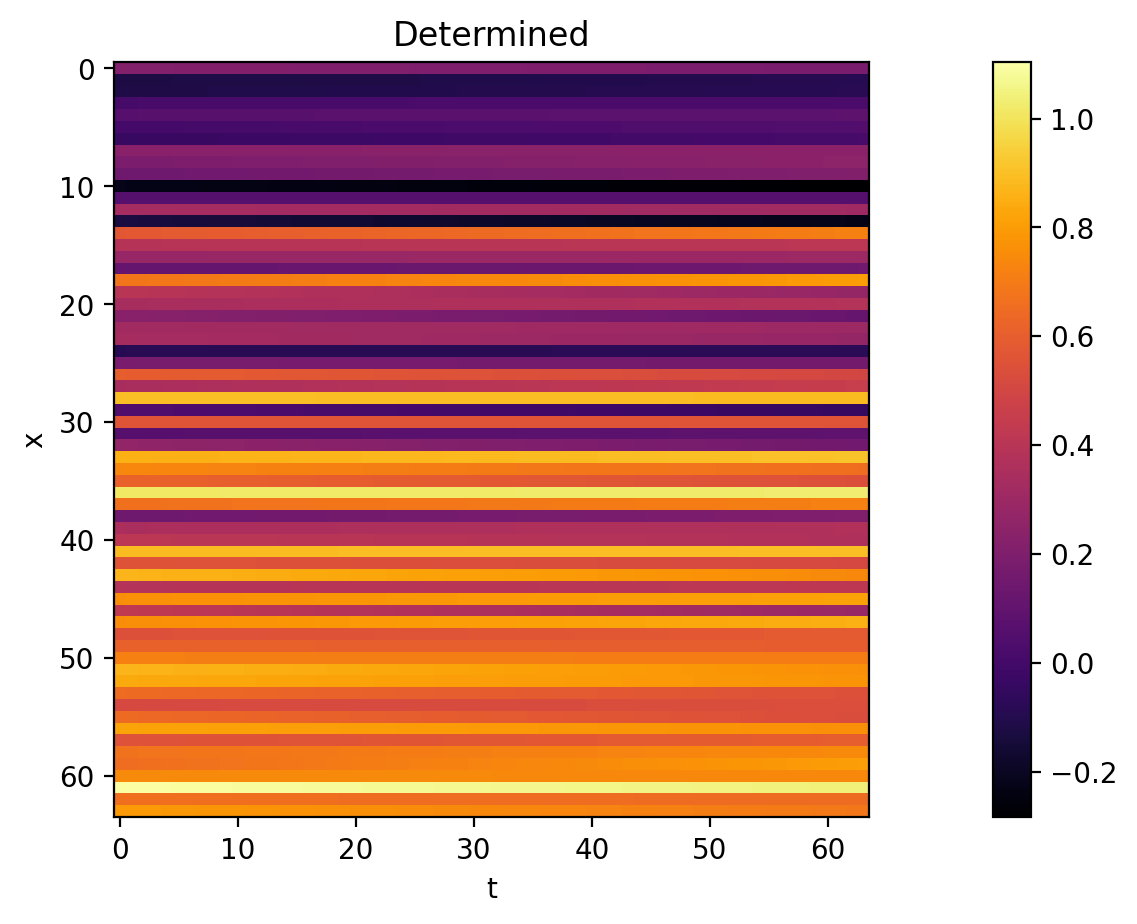

Epoch 91 loss 0.279851
Epoch 92 loss 0.279851
Epoch 93 loss 0.279851
Epoch 94 loss 0.279851
Epoch 95 loss 0.279851
Epoch 96 loss 0.279851
Epoch 97 loss 0.279851
Epoch 98 loss 0.279851
Epoch 99 loss 0.279851
Epoch 100 loss 0.279851


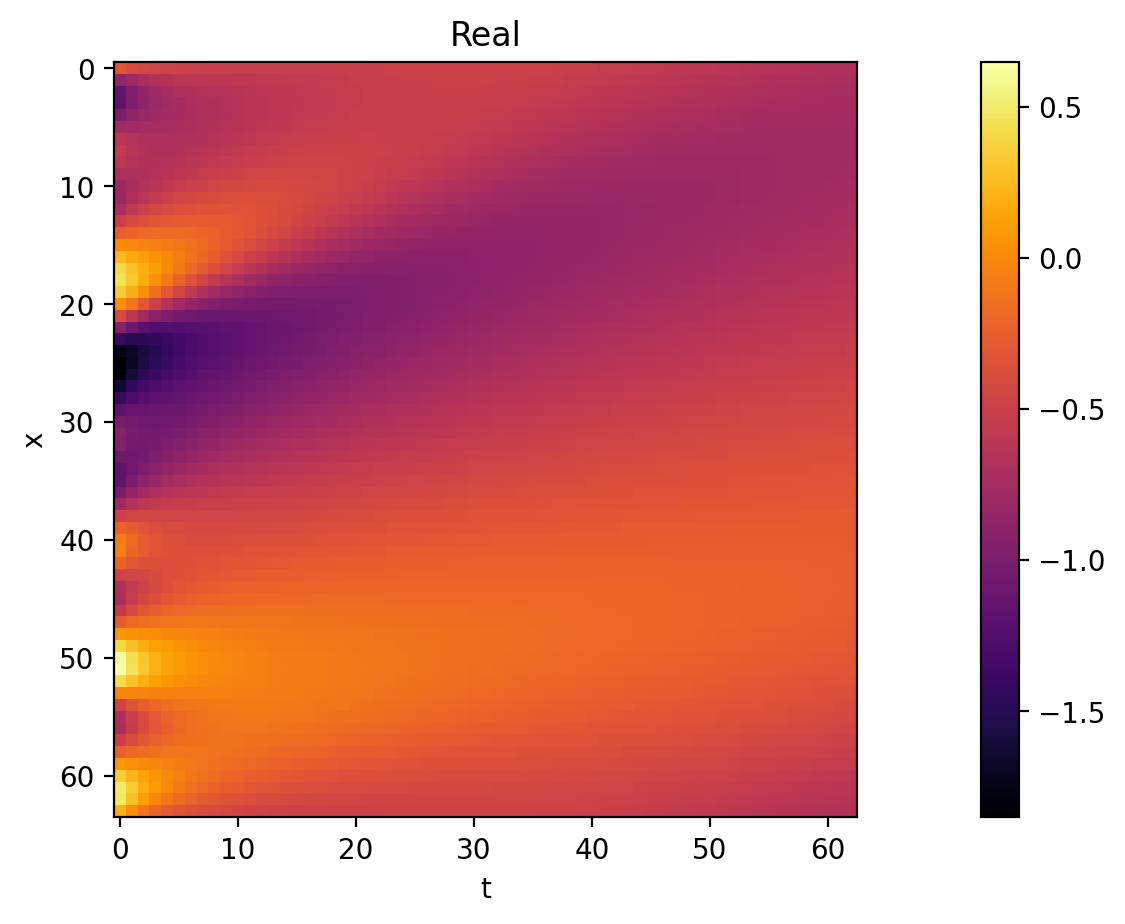

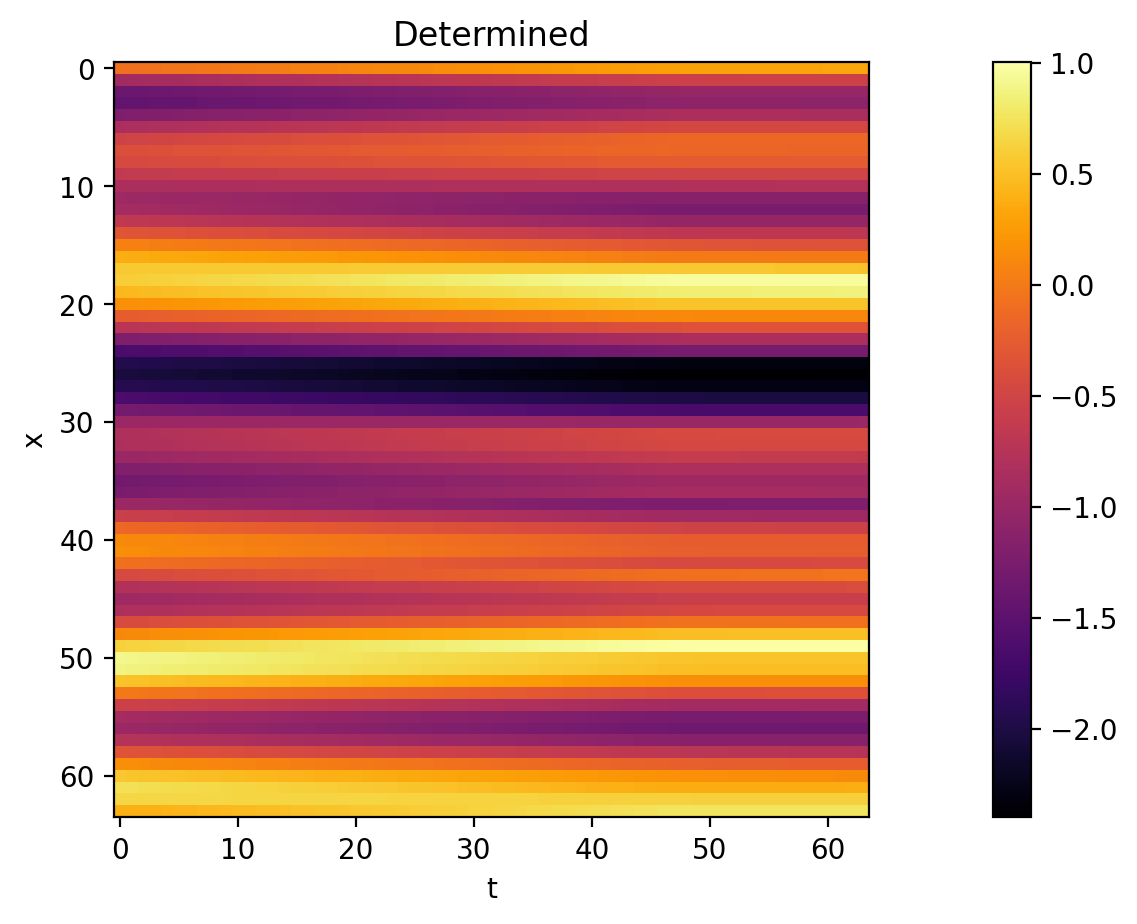

In [95]:
%matplotlib inline

# Experiment 1 - Linear operator, nu=0.003, epoch=2
net = BurgersModelA(x_n)
F = training_ode_solver_net(net, 100, t_n, x_n, training_set[0:1], 101, [], -1)

### Training - Discrete residual

In [72]:
def training_discrete_residual_net(net, epochs, t_n, x_n, dataset, val_epoch=10, rands=[], downsize=0):
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    training_batch_size = len(dataset)
    training_set_idx = np.arange(0, training_batch_size)
    
    tr_min_t = 1
    tr_max_t = int(len(dataset[0][0]) / 5 * 3)
    val_max_t = int(tr_max_t + len(dataset[0][0]) / 5 * 2)
    
    for e in range(1, epochs + 1):
        loss_tot = 0
        val_loss_tot = 0
        np.random.shuffle(training_set_idx)
        
        # === Train ===
        net.train()
        for i in training_set_idx:
            # === Randomness ====
            rand = -1
            if (i < len(rands)):
                rand = rands[i]
            
            optimizer.zero_grad()
            
            t, bu, _, _ = dataset[i]
            tr_t =  t[tr_min_t:tr_max_t]
            tr_b0 = bu[tr_min_t, :]
            tr_bu = bu[tr_min_t:tr_max_t, :]
            
            pred_u = np.zeros(tr_bu.shape)
            pred_u[0, :] = np.copy(tr_b0)
            for i in range(1, tr_bu.shape[0]):
                tmp = net(t[i], torch.from_numpy(pred_u[i-1, :]).float())
                pred_u[i, :] = tmp.clone().detach().numpy()
                loss = loss_fn(tmp.T, tr_bu[i].T)
                loss_tot += loss.item()
            
            loss.backward(retain_graph=False) # retain_graph=True if 2+ losses
            optimizer.step()
        
        print('Epoch %d loss %f'%(e, float(loss_tot / float(training_batch_size))))
        
        # === Evaluate ===
        net.eval()
        if (e > val_epoch):
            for j in training_set_idx:
                t, bu, _, _ = dataset[j]
                val_t = t[tr_max_t:val_max_t]
                val_b0 = bu[tr_max_t, :]
                val_bu = bu[tr_max_t:val_max_t, :]
                
                val_pred_u = odeint(net, val_b0, val_t)
                val_loss = loss_fn(val_pred_u.T, val_bu.T)
                val_loss_tot += val_loss.item()
            print('Epoch %d validation loss %f'%(e, float(val_loss_tot / float(training_batch_size))))
        
        if e % 10 == 0:
            sample_t, sample_b0, sample_real = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, rand, -1)
            sample_b0 = sample_real[1, :]
            # sample_pred = odeint(net, sample_b0, sample_t[1:])
            sample_pred = odeint(net, sample_b0, torch.from_numpy(np.linspace(0,5,640)).float())
            show_state(sample_real[1:].T, 'Real', 't', 'x', None)
            show_state(sample_pred.detach().numpy().T, 'Determined', 't', 'x', None)
    
    return net

Epoch 1 loss 8.634018
Epoch 2 loss 9.596690
Epoch 3 loss 9.267833
Epoch 4 loss 9.402424
Epoch 5 loss 12.691093
Epoch 6 loss 13.848597
Epoch 6 validation loss 0.004209
Epoch 7 loss 10.843632
Epoch 7 validation loss 0.004179
Epoch 8 loss 10.416436
Epoch 8 validation loss 0.004150
Epoch 9 loss 10.354742
Epoch 9 validation loss 0.004125
Epoch 10 loss 10.201678
Epoch 10 validation loss 0.004110


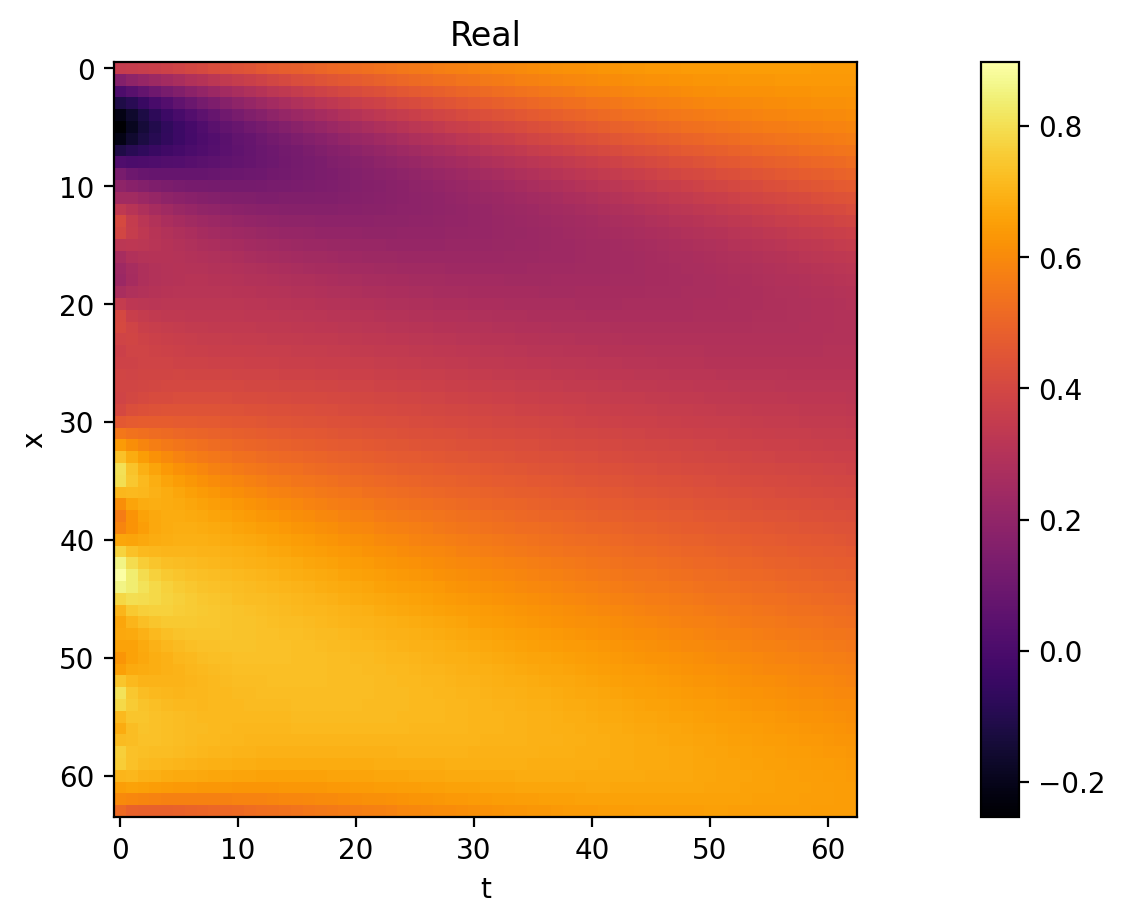

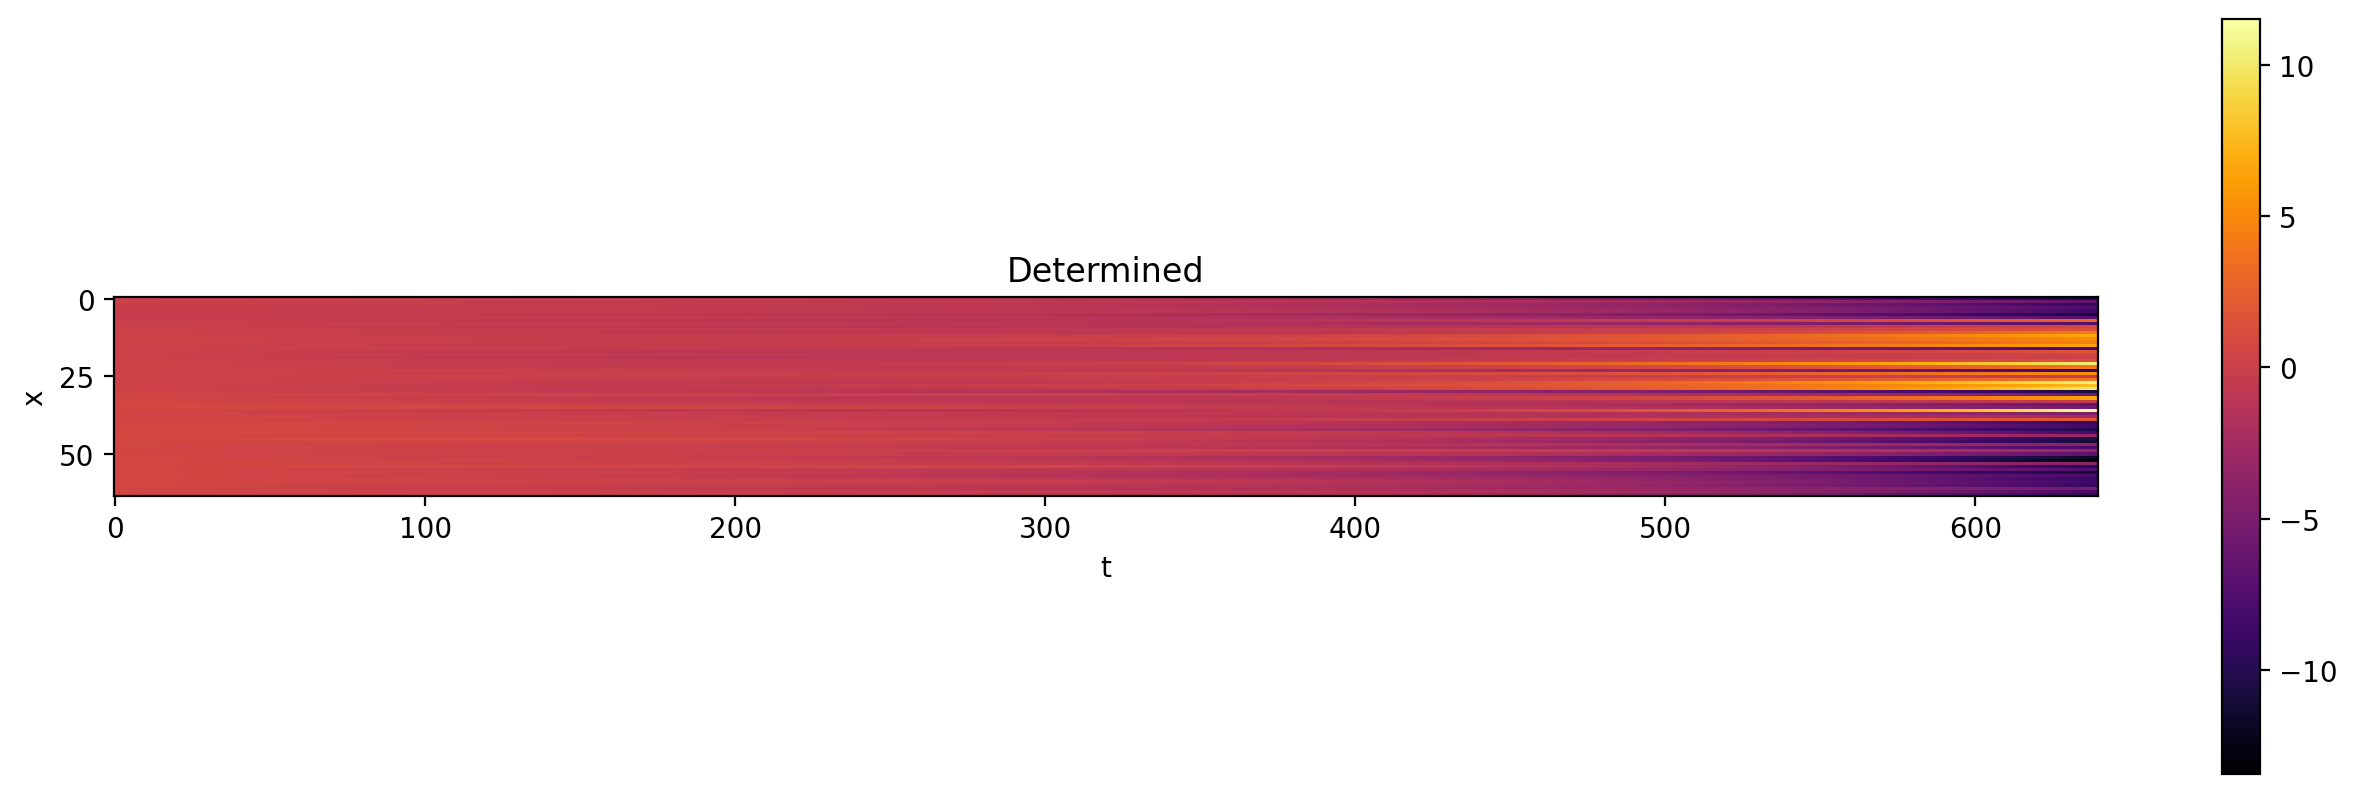

Epoch 11 loss 10.192000
Epoch 11 validation loss 0.004086
Epoch 12 loss 10.203689
Epoch 12 validation loss 0.004078
Epoch 13 loss 10.096344
Epoch 13 validation loss 0.004060
Epoch 14 loss 10.155830
Epoch 14 validation loss 0.004060
Epoch 15 loss 10.170426
Epoch 15 validation loss 0.004053
Epoch 16 loss 10.166909
Epoch 16 validation loss 0.004047
Epoch 17 loss 10.267587
Epoch 17 validation loss 0.004053
Epoch 18 loss 10.986109
Epoch 18 validation loss 0.004045
Epoch 19 loss 10.329081
Epoch 19 validation loss 0.004013
Epoch 20 loss 10.578952
Epoch 20 validation loss 0.003953


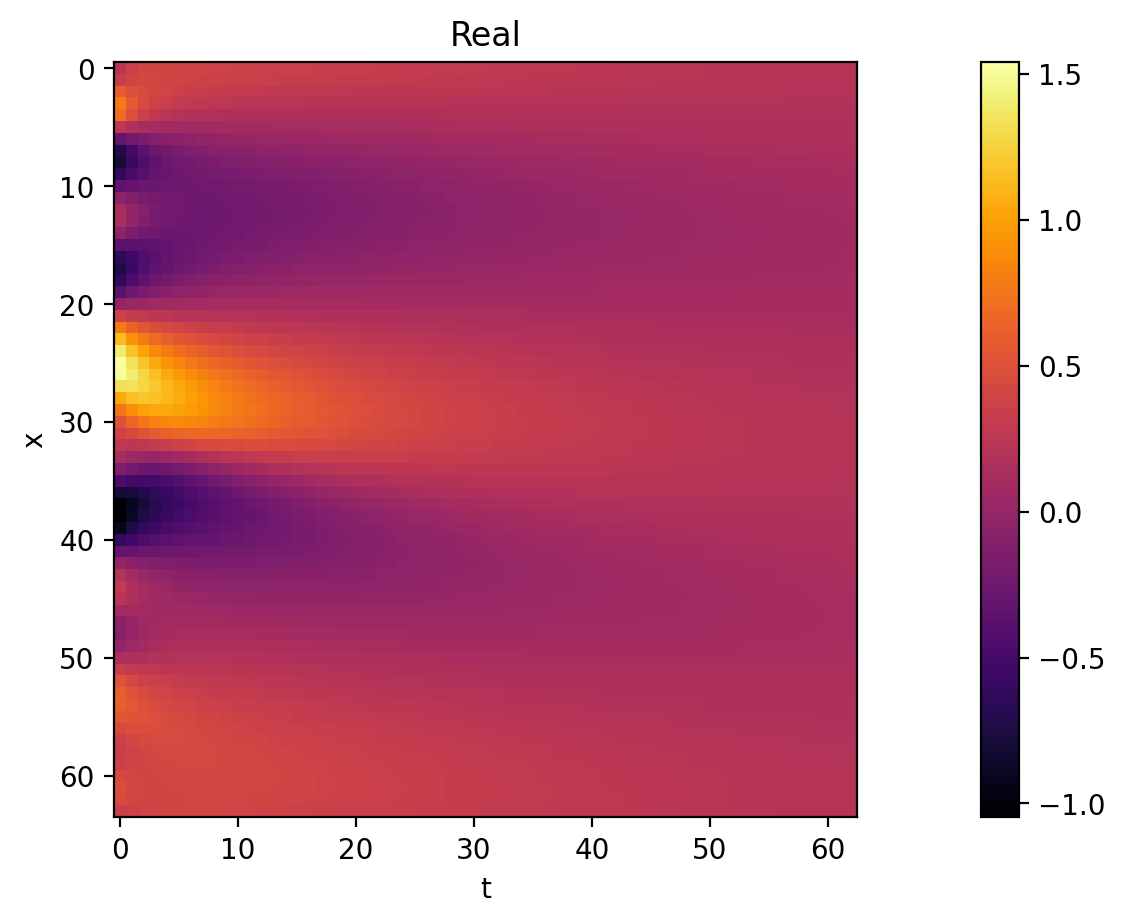

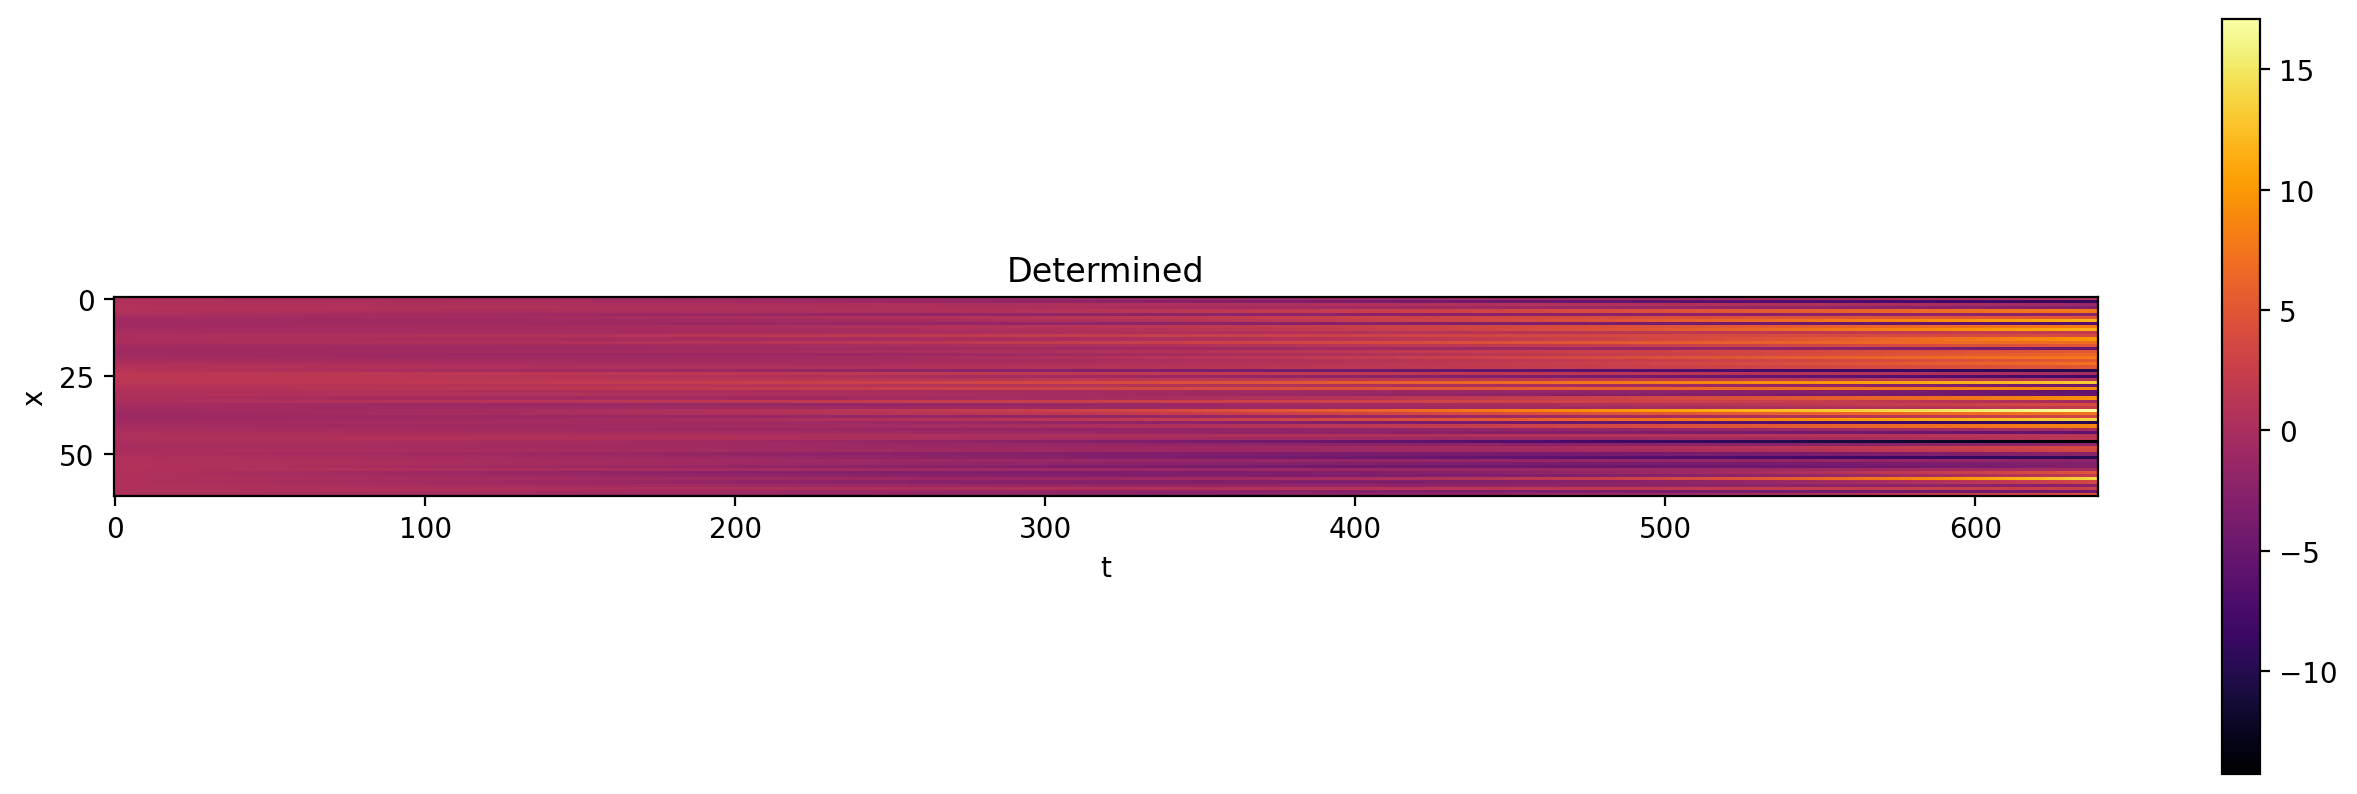

Epoch 21 loss 9.974244
Epoch 21 validation loss 0.003954
Epoch 22 loss 10.059509
Epoch 22 validation loss 0.003938
Epoch 23 loss 10.104226
Epoch 23 validation loss 0.003947
Epoch 24 loss 10.160152
Epoch 24 validation loss 0.003952
Epoch 25 loss 10.427087
Epoch 25 validation loss 0.003942
Epoch 26 loss 10.587768
Epoch 26 validation loss 0.003934
Epoch 27 loss 10.573644
Epoch 27 validation loss 0.003893
Epoch 28 loss 10.674846
Epoch 28 validation loss 0.003843
Epoch 29 loss 11.717922
Epoch 29 validation loss 0.003727
Epoch 30 loss 43122674254329.257812
Epoch 30 validation loss 0.004415


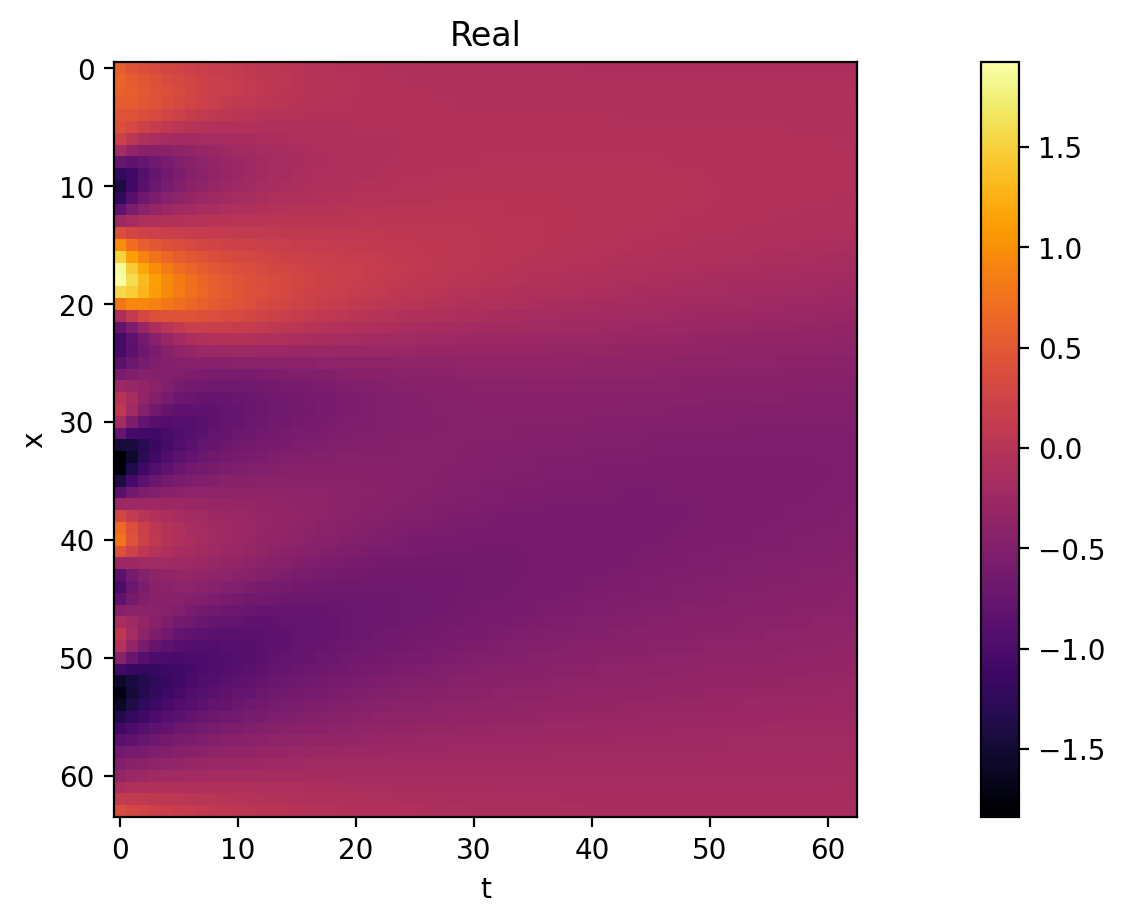

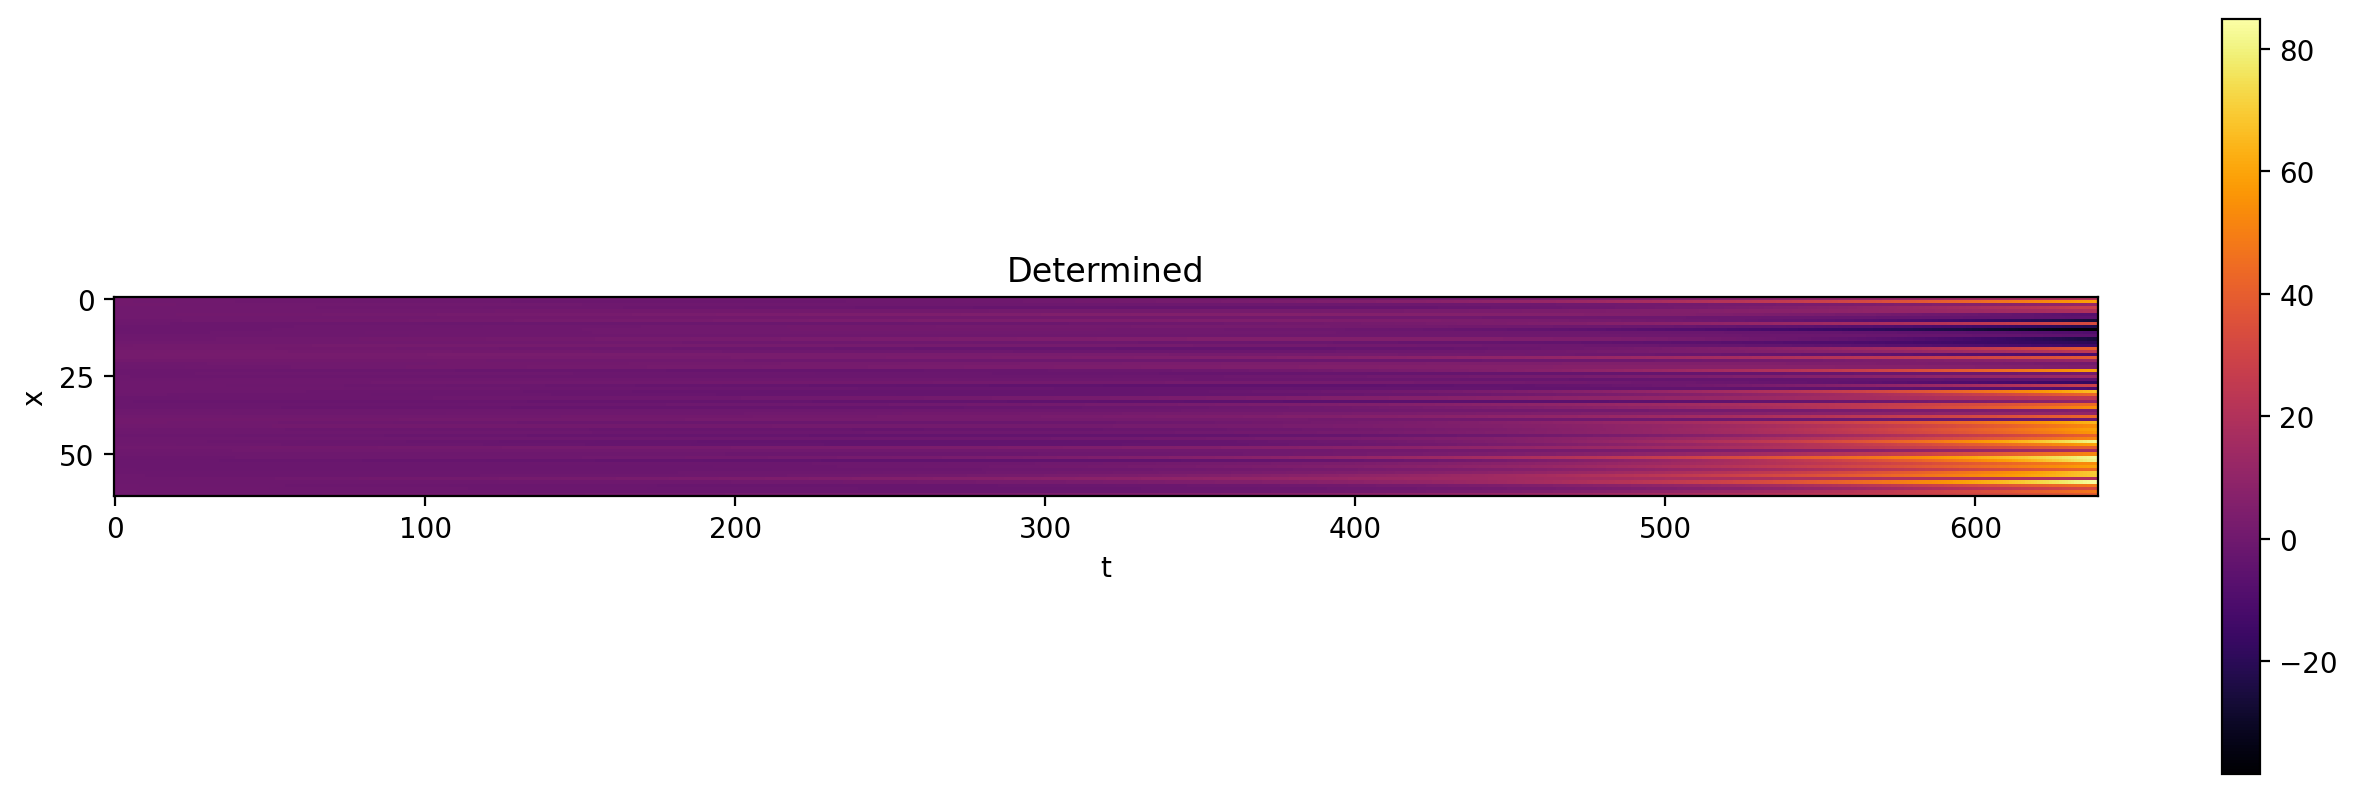

Epoch 31 loss 5225076987625933323108352.000000
Epoch 31 validation loss 0.004412
Epoch 32 loss 16279138475424112307077120.000000
Epoch 32 validation loss 0.004613
Epoch 33 loss 22087121459726871464771584.000000
Epoch 33 validation loss 0.005422
Epoch 34 loss 36946258230888757375008768.000000
Epoch 34 validation loss 0.006924
Epoch 35 loss 62674878313631039430328320.000000
Epoch 35 validation loss 0.009623
Epoch 36 loss 101990049842601465294618624.000000
Epoch 36 validation loss 0.013535
Epoch 37 loss 153275744317080763046559744.000000
Epoch 37 validation loss 0.018830
Epoch 38 loss 217867914819814174486429696.000000
Epoch 38 validation loss 0.024950
Epoch 39 loss 292062641132068330136403968.000000
Epoch 39 validation loss 0.031847
Epoch 40 loss 373861792938056423223328768.000000
Epoch 40 validation loss 0.039566


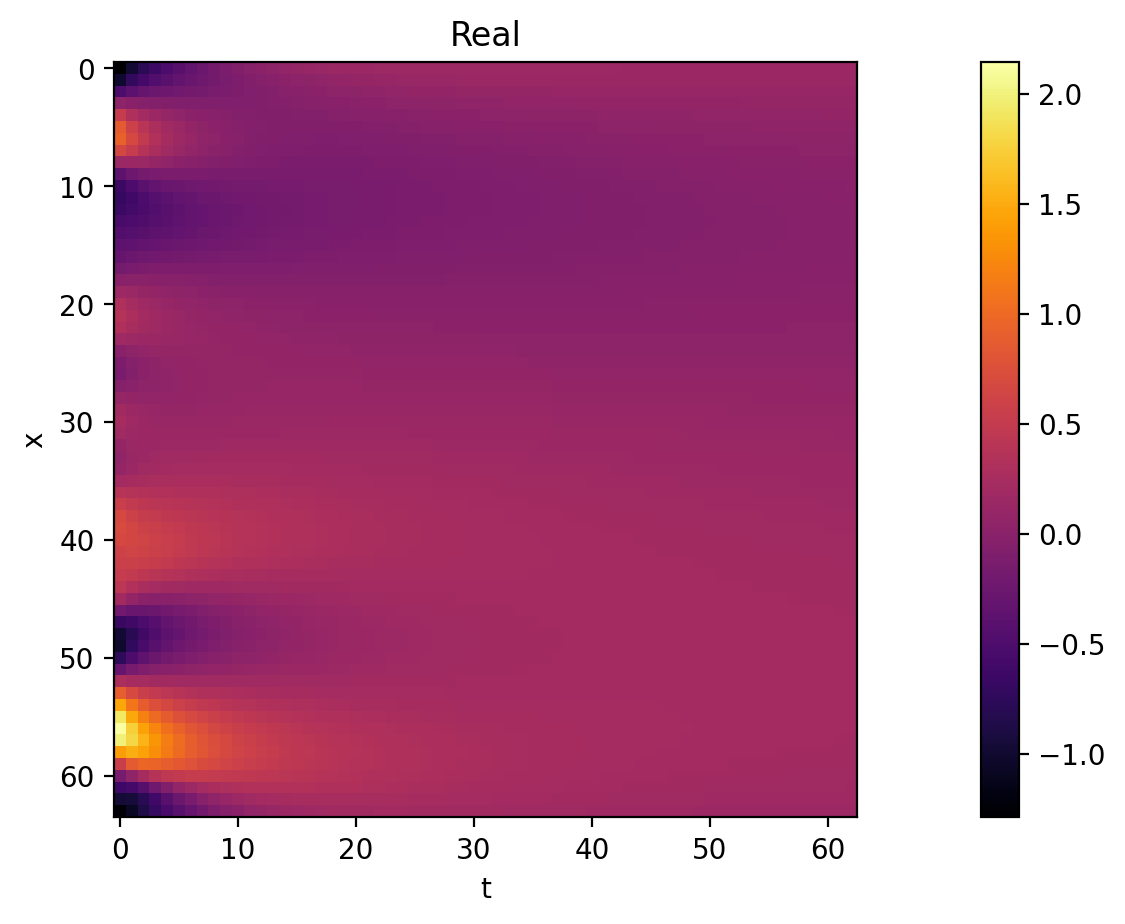

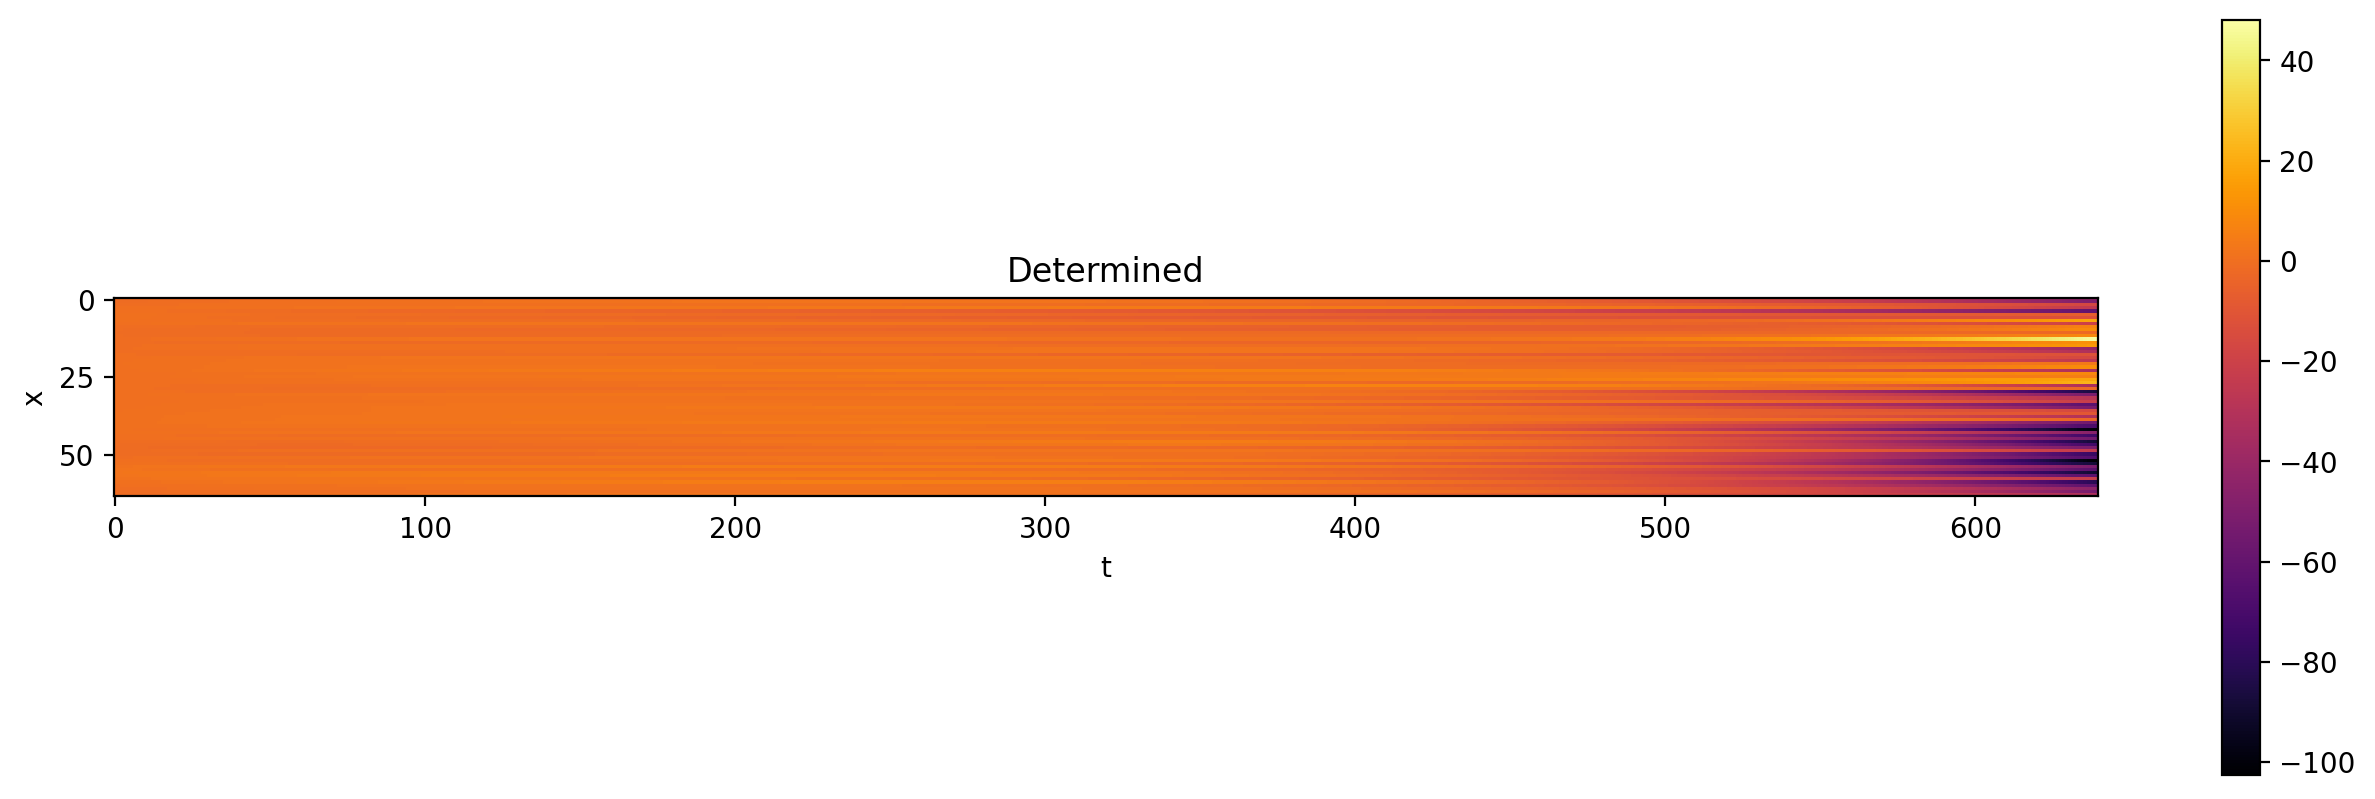

Epoch 41 loss 463825972094171039804686336.000000
Epoch 41 validation loss 0.047728
Epoch 42 loss 558664701148202967326785536.000000
Epoch 42 validation loss 0.056558
Epoch 43 loss 660172581937959905192312832.000000
Epoch 43 validation loss 0.065696
Epoch 44 loss 765374466382939885158793216.000000
Epoch 44 validation loss 0.075411
Epoch 45 loss 875596091606806327933796352.000000
Epoch 45 validation loss 0.085458
Epoch 46 loss 989440110044497443664429056.000000
Epoch 46 validation loss 0.095924
Epoch 47 loss 1106966887960262875526725632.000000
Epoch 47 validation loss 0.106757
Epoch 48 loss 1228914985017486133856043008.000000
Epoch 48 validation loss 0.117718
Epoch 49 loss 1353006413961952964219240448.000000
Epoch 49 validation loss 0.129105
Epoch 50 loss 1480450844215336706685009920.000000
Epoch 50 validation loss 0.140810


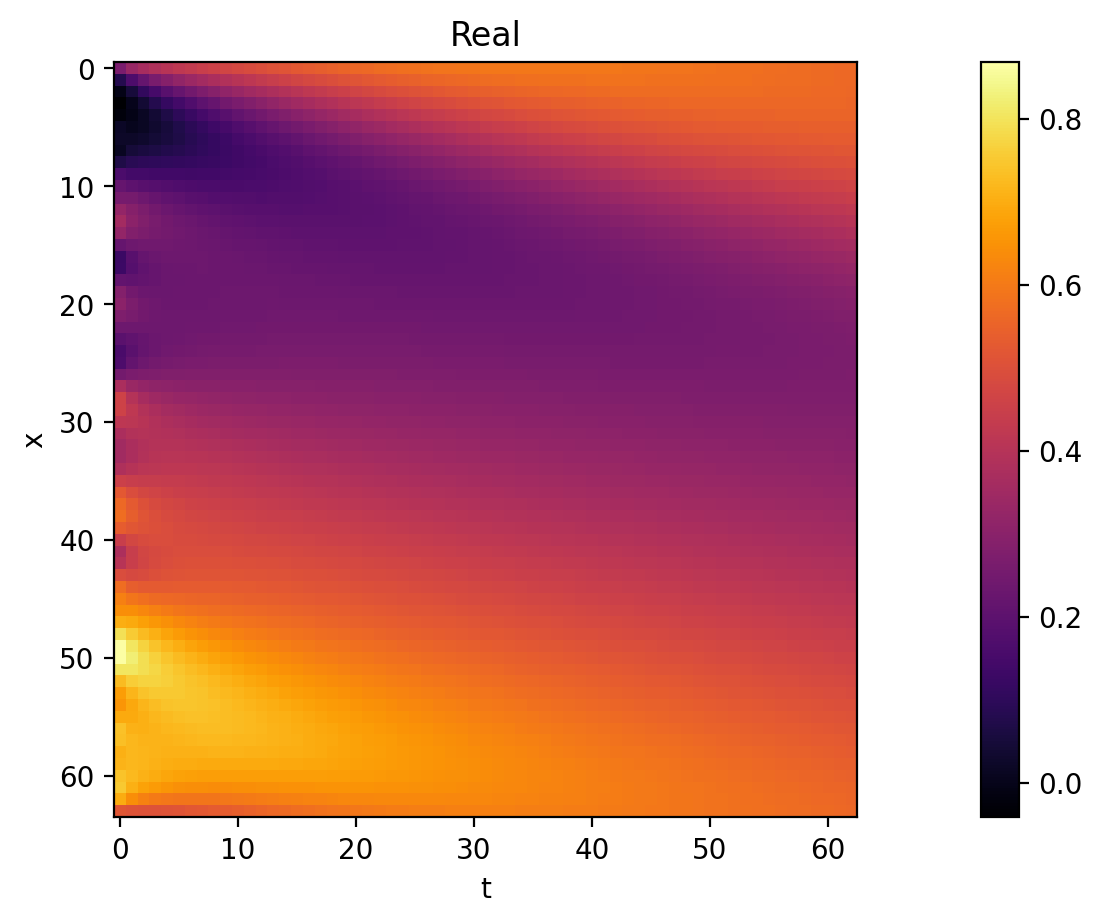

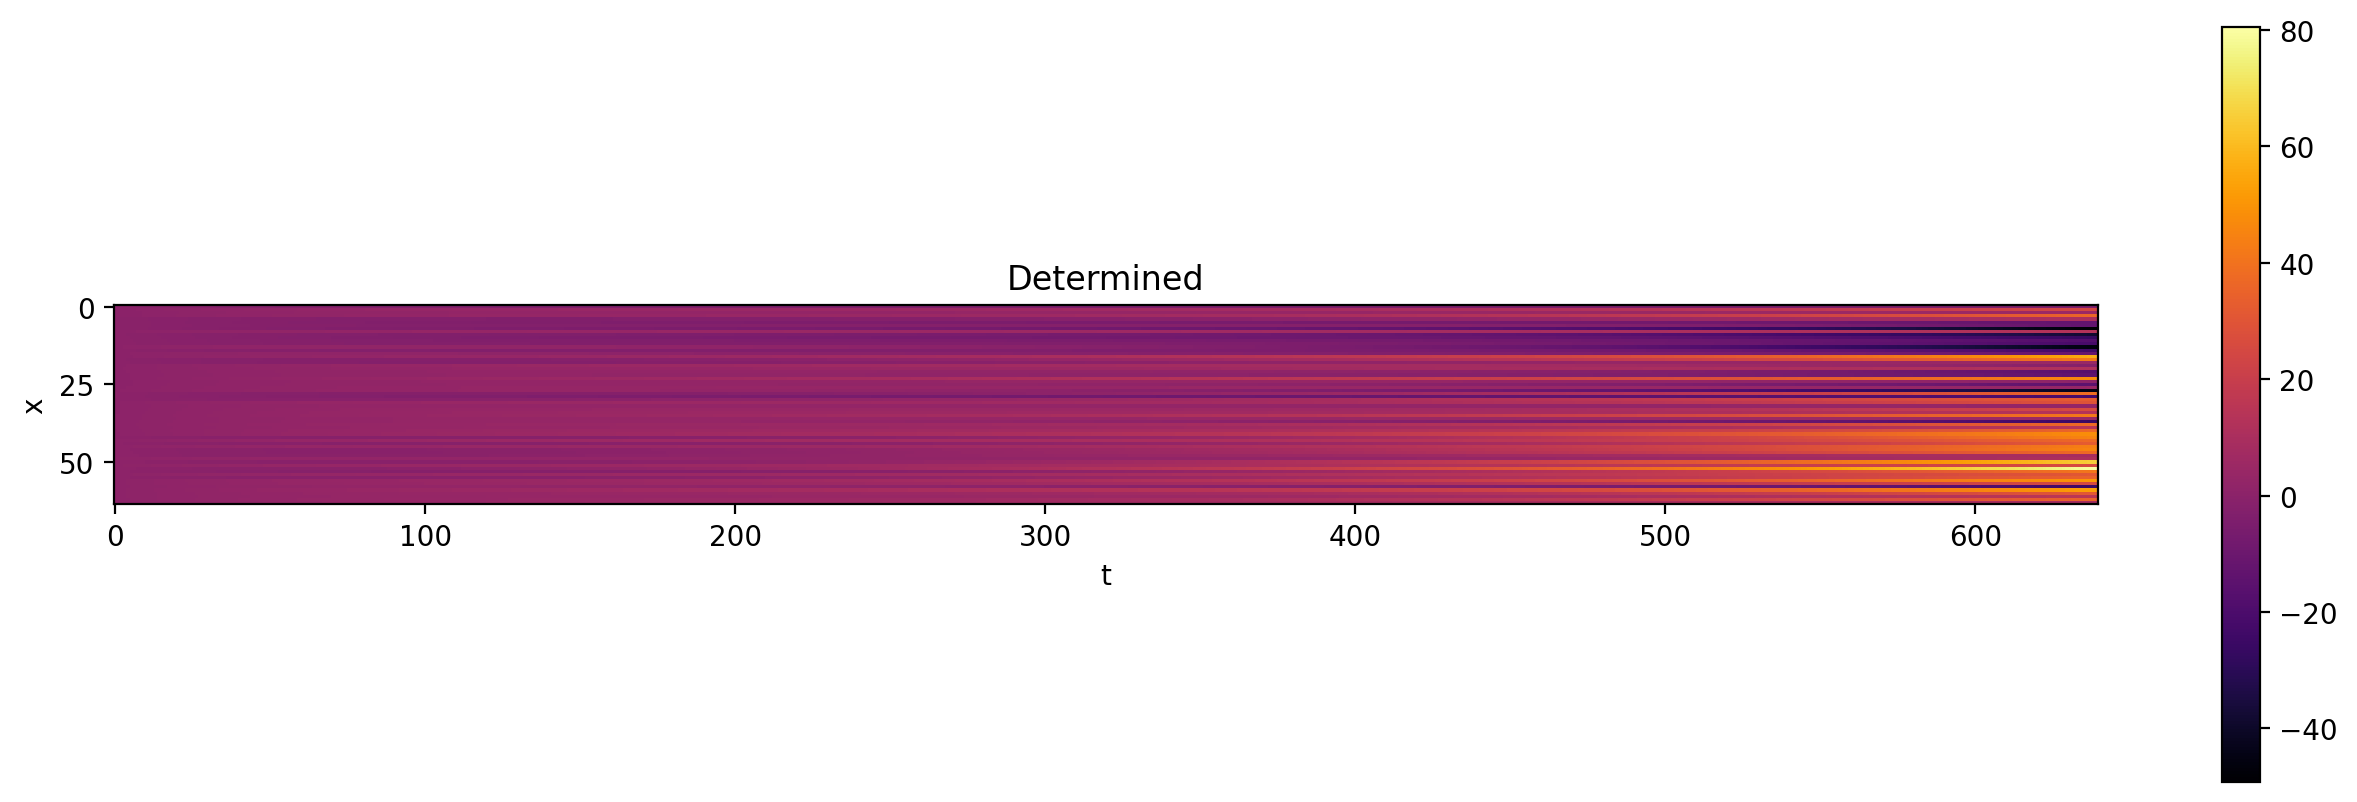

Epoch 51 loss 1611467402604656945711284224.000000
Epoch 51 validation loss 0.152686
Epoch 52 loss 1744669094537095594375118848.000000
Epoch 52 validation loss 0.164908
Epoch 53 loss 1881606176190565241992511488.000000
Epoch 53 validation loss 0.177243
Epoch 54 loss 2020157613678246307175596032.000000
Epoch 54 validation loss 0.189963
Epoch 55 loss 2162212212689684075957452800.000000
Epoch 55 validation loss 0.202829
Epoch 56 loss 2306453299663997564354560000.000000
Epoch 56 validation loss 0.215957
Epoch 57 loss 2453201931104038344630206464.000000
Epoch 57 validation loss 0.229330
Epoch 58 loss 2602457069787569265672454144.000000
Epoch 58 validation loss 0.242932
Epoch 59 loss 2753986749452711076877565952.000000
Epoch 59 validation loss 0.256797
Epoch 60 loss 2908208501252967198581850112.000000
Epoch 60 validation loss 0.270827


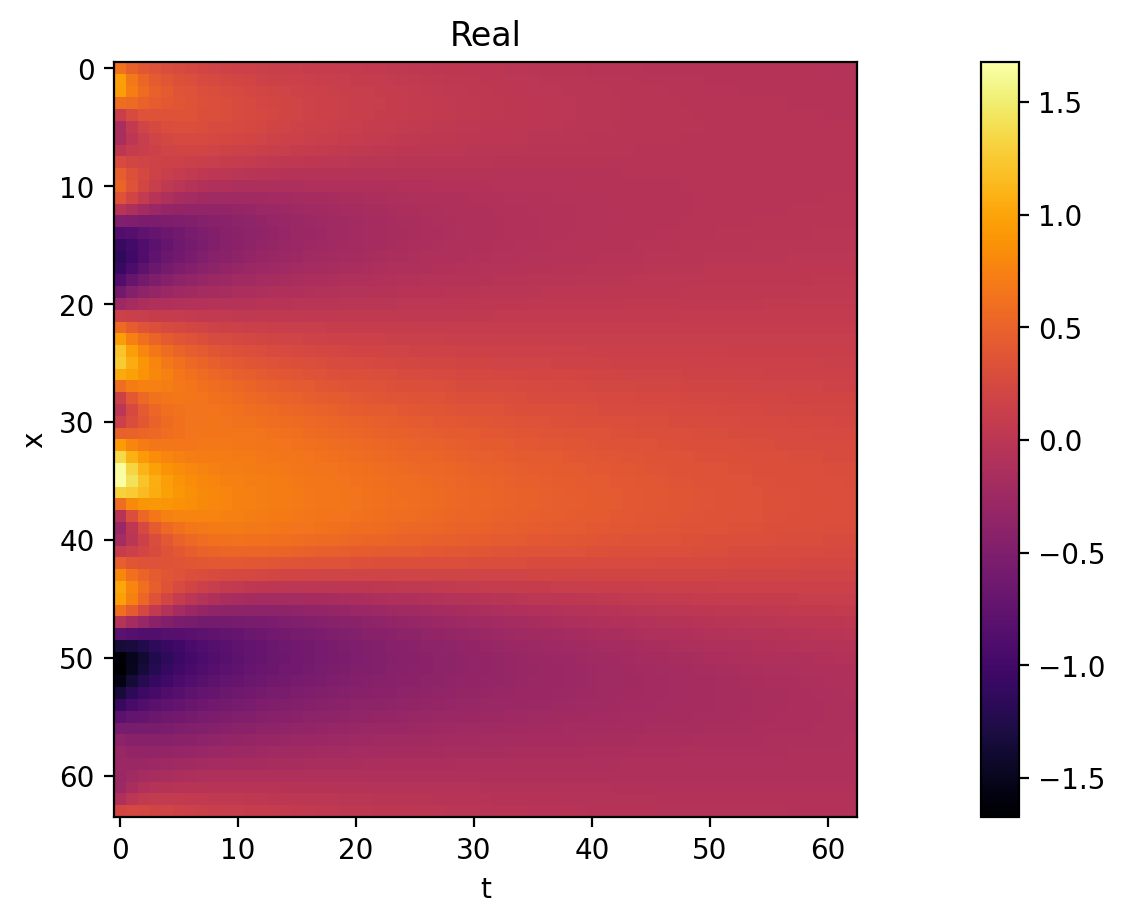

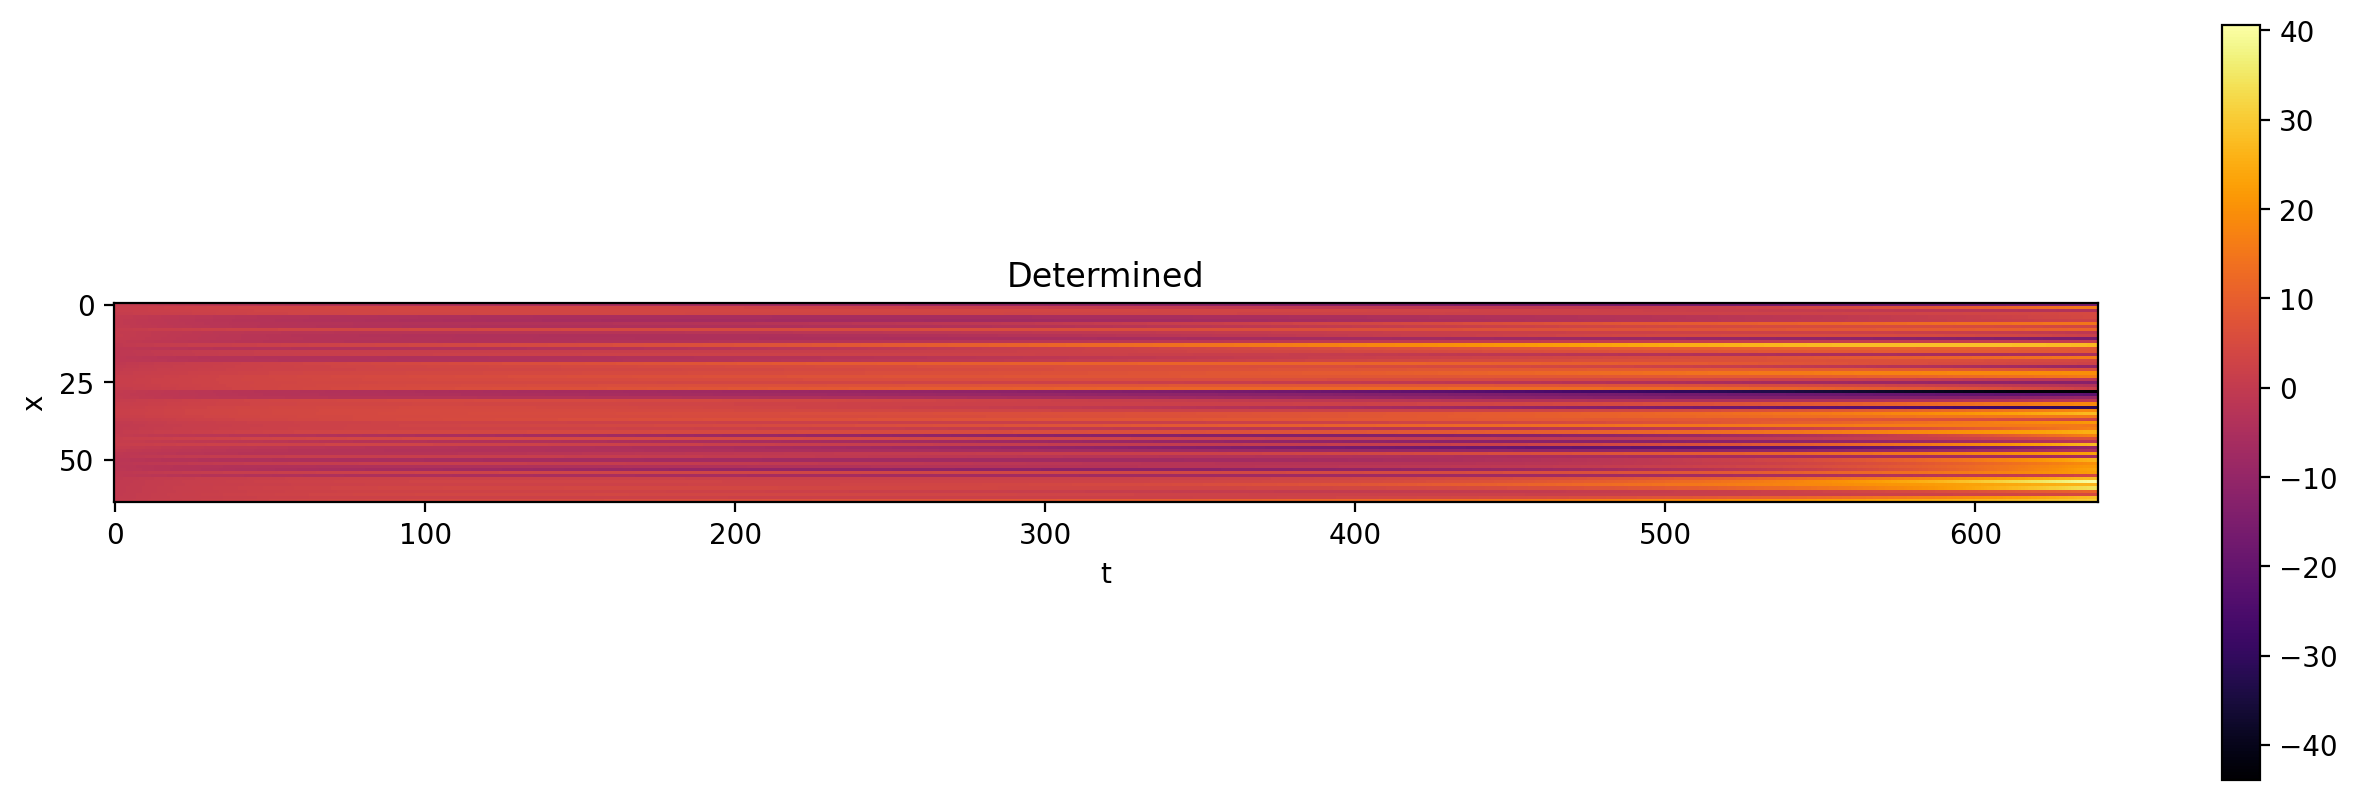

Epoch 61 loss 3064215865367445423511306240.000000
Epoch 61 validation loss 0.285151
Epoch 62 loss 3223340920311855431320338432.000000
Epoch 62 validation loss 0.299537
Epoch 63 loss 3383850097537432168878309376.000000
Epoch 63 validation loss 0.314247
Epoch 64 loss 3547677081614019436289720320.000000
Epoch 64 validation loss 0.328973
Epoch 65 loss 3712244734208186682859061248.000000
Epoch 65 validation loss 0.344134
Epoch 66 loss 3879995917013866244334419968.000000
Epoch 66 validation loss 0.359419
Epoch 67 loss 4049855871105992884433715200.000000
Epoch 67 validation loss 0.374849
Epoch 68 loss 4221639435198962385421336576.000000
Epoch 68 validation loss 0.390486
Epoch 69 loss 4395139409947425455619440640.000000
Epoch 69 validation loss 0.406425
Epoch 70 loss 4571207344382491088490856448.000000
Epoch 70 validation loss 0.422515


KeyboardInterrupt: 

In [80]:
net2 = BurgersModelB(x_n)
F2 = training_discrete_residual_net(net2, 10, t_n, x_n, training_set[0:32], 5, [], -1)

## Visualization

Let's train this basic NN and visualize its efficiency to match the solution u(t,x)

In [ ]:
def check_efficiency(net, n_sim=10, debug=False):
    rmse_tot = 0
    
    for i in range(n_sim):
        t, b0, bu = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, -1, -1)
        pred_u = odeint(net, b0, t).detach().numpy()
        u = bu.detach().numpy()
        rmse_tot += rmse(pred_u.T, u.T)

        if debug:
            print("RMSE = ", rmse(pred_u.T, u.T))
            show_err(np.abs(pred_u.T - u.T), 'Error NN vs. Real', 't', 'x', None)
            show_state(u.T, 'Real', 't', 'x', None)
            show_state(pred_u.T, 'Expected', 't', 'x', None)
            
    return rmse_tot / n_sim

In [ ]:
check_weights(F)

In [ ]:
print(check_efficiency(F, 1, True))

In [ ]:
def training_ode_solver_net(net, epochs=100, t_n=20, x_n=100, nu=0.003, batch_size=10):
    optimizer = optim.RMSprop(net.parameters(), lr=0.003)

    for e in range(1, epochs + 1):
        print("Epoch ", e)
        loss_tot = 0
        val_loss_tot = 0
        
        net.train()
        for i in range(batch_size):
            print("Batch ", i)
            optimizer.zero_grad()
            t, b0, bu = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, -1, 0)
            pred_u = odeint(net, b0[1:-1], t)
            loss = loss_fn(pred_u, bu[:, 1:-1])
            loss_tot += loss.item()
            
            loss.backward(retain_graph=True)
            optimizer.step()

        if e % 1 == 0:
            t, b0, bu = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, -1, 0)
            visualize_u_from_F(net, t, bu[:,1:-1], b0[1:-1])
            
            print('Epoch %d loss %f'%(e, float(loss_tot / float(batch_size))))
    
    return net